## Imports

In [35]:
import pandas as pd
import numpy as np
import yfinance as yf #
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from arch import arch_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen 

import pandas_ta as ta
from pandas.tseries.offsets import BDay 
import matplotlib.dates as mdates 

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna with 'method' is deprecated.*")

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
# Set figure size for plots
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
ticker_symbol = "GC=F"
tickers_to_compare = ['GC=F', 'DX-Y.NYB', '^TNX', '^GSPC', 'SI=F']
data_period = "10y"
N_plot_days = 100 # Technical indicator plotted days

# Configuration ML forecasting
PREDICTION_TARGET = 'Close' # Predict 'Close' price or 'Log Return'
N_LAG_FEATURES = 5          # Number of past days' price/return to use as features
N_ROLLING_FEATURES = 30     # Window size for rolling mean/std features
FORECAST_HORIZON = 10       # Predict 1 day ahead
TEST_SIZE = 0.2             # Use last 20% of data for testing
LSTM_LOOKBACK = 60          # Use last 60 days of data to predict the next day for LSTM

tickers_var = ['GC=F', 'DX-Y.NYB', '^TNX']

## Implementation

In [4]:
gold_data = yf.Ticker(ticker_symbol)
hist_df = gold_data.history(period=data_period)
gold_price = hist_df[['Close']].copy()

In [5]:
gold_price['Daily Return'] = gold_price['Close'].pct_change()

# Calculate Daily Logarithmic Return
gold_price['Log Return'] = np.log(gold_price['Close'] / gold_price['Close'].shift(1))

gold_price = gold_price.dropna()

gold_price_close = gold_price['Close'].copy()

In [6]:
rolling_window_short = 30
rolling_window_long = 252

gold_price['Rolling Volatility (30d)'] = gold_price['Log Return'].rolling(window=rolling_window_short).std() * np.sqrt(252)
gold_price['Rolling Volatility (252d)'] = gold_price['Log Return'].rolling(window=rolling_window_long).std() * np.sqrt(252)


In [8]:
 # Gold, DXY, 10Y Yield, S&P 500
combined_data = yf.download(tickers_to_compare, period=data_period)['Close']
combined_data = combined_data.pct_change().dropna()
correlation_matrix = combined_data.corr()

[*********************100%***********************]  5 of 5 completed
/var/folders/wz/8tgpjswj4fg0909bddvzc2500000gn/T/ipykernel_12286/450730587.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  combined_data = combined_data.pct_change().dropna()


In [9]:
result_adf = adfuller(gold_price['Log Return'].dropna())
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}') # p < 0.05 indicates stationarity


ADF Statistic: -50.848601459284104
p-value: 0.0


In [10]:
order = (5, 1, 0)
model = ARIMA(gold_price_close, order=order)
model_fit = model.fit()
print(model_fit.summary())

# --- Generate Forecast ---
forecast_steps = 30 # Number of steps (days) to forecast
forecast_result = model_fit.get_forecast(steps=forecast_steps)

# Get the forecast mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int(alpha=0.05) # 95% CI

# --- Create Date Index for Forecast ---
# Use the last date in the original index to generate future dates
last_date = gold_price_close.index[-1]

# Generate future dates using the inferred or assigned frequency if available
if hasattr(gold_price_close.index, 'freq') and gold_price_close.index.freq is not None:
    forecast_index = pd.date_range(start=last_date + gold_price_close.index.freq,
                                   periods=forecast_steps,
                                   freq=gold_price_close.index.freq)
else:
    # If frequency ('B') couldn't be set, default to daily steps for plotting,
    # acknowledging it might not perfectly match trading days.
    print("Warning: Index frequency not set. Using daily steps for forecast index.")
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                   periods=forecast_steps)


# --- Combine Forecast with Index ---
forecast_df = pd.DataFrame({'mean': forecast_mean.values,
                            'mean_ci_lower': confidence_intervals.iloc[:, 0].values,
                            'mean_ci_upper': confidence_intervals.iloc[:, 1].values},
                           index=forecast_index)



/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2514
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10635.893
Date:                Thu, 17 Apr 2025   AIC                          21283.787
Time:                        18:03:12   BIC                          21318.762
Sample:                             0   HQIC                         21296.481
                               - 2514                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0013      0.014      0.093      0.926      -0.026       0.029
ar.L2         -0.0068      0.015     -0.460      0.646      -0.036       0.022
ar.L3          0.0151      0.014      1.052      0.2

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
ml_data = gold_price[['Close', 'Log Return']].copy()

# --- Create Target Variable ---
# Shift the target column up by the forecast horizon to represent the future value we want to predict
ml_data['Target'] = ml_data[PREDICTION_TARGET].shift(-FORECAST_HORIZON)

# --- Create Lag Features ---
for i in range(1, N_LAG_FEATURES + 1):
    ml_data[f'Lag_{i}'] = ml_data[PREDICTION_TARGET].shift(i)

# --- Create Rolling Features ---
ml_data['Rolling_Mean'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).mean()
ml_data['Rolling_Std'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).std()

In [12]:
try:
    dxy_ticker = "DX-Y.NYB"
    dxy_data = yf.Ticker(dxy_ticker).history(period=data_period)['Close']
    dxy_data.name = 'DXY_Close'
    ml_data = ml_data.join(dxy_data)
    ml_data['DXY_Lag_1'] = ml_data['DXY_Close'].shift(1) # Use lagged value
    ml_data.drop('DXY_Close', axis=1, inplace=True) # Drop current DXY to avoid lookahead
    print("Added DXY data as a feature.")
except Exception as e:
    print(f"Could not fetch or merge DXY data: {e}")
#Add other tickers similarly (^TNX for rates, ^GSPC for S&P500, CL=F for oil, ^VIX)

Added DXY data as a feature.


In [13]:
ml_data = ml_data.dropna()

# --- Define Features (X) and Target (y) ---
features = [col for col in ml_data.columns if col not in ['Close', 'Log Return', 'Target']]
X = ml_data[features]
y = ml_data['Target']

In [14]:
print("--- Features for ML Models ---")
print(X.head())
print("\n--- Target Variable ---")
print(y.head())
print(f"\nShape of X: {X.shape}, Shape of y: {y.shape}")

--- Features for ML Models ---
                                 Lag_1        Lag_2        Lag_3        Lag_4  \
Date                                                                            
2015-06-15 00:00:00-04:00  1178.800049  1179.900024  1186.099976  1177.300049   
2015-06-16 00:00:00-04:00  1185.300049  1178.800049  1179.900024  1186.099976   
2015-06-17 00:00:00-04:00  1180.500000  1185.300049  1178.800049  1179.900024   
2015-06-18 00:00:00-04:00  1176.400024  1180.500000  1185.300049  1178.800049   
2015-06-19 00:00:00-04:00  1201.500000  1176.400024  1180.500000  1185.300049   

                                 Lag_5  Rolling_Mean  Rolling_Std  DXY_Lag_1  
Date                                                                          
2015-06-15 00:00:00-04:00  1173.199951   1197.166679    14.734333  94.970001  
2015-06-16 00:00:00-04:00  1177.300049   1197.186678    14.729591  94.809998  
2015-06-17 00:00:00-04:00  1186.099976   1196.580009    14.860384  95.000000  
2015-0

In [15]:
split_index = int(len(X) * (1 - TEST_SIZE))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set size: X={X_train.shape}, y={y_train.shape}")
print(f"Test set size: X={X_test.shape}, y={y_test.shape}")

# --- Scaling Features (Optional but often recommended for SVR, required for LSTM) ---
# Scale based on the training set ONLY to prevent data leakage
scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Scale the target variable separately if needed (esp. for LSTM evaluation)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) # Use transform only


Training set size: X=(1972, 8), y=(1972,)
Test set size: X=(493, 8), y=(493,)


In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(), # Sensitive to scaling, use X_train_scaled
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), # n_jobs=-1 uses all cores
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# --- Train and Evaluate ---
for name, model in models.items():
    print(f"--- Training {name} ---")
    if name == "SVR": # Use scaled data for SVR
        model.fit(X_train_scaled, y_train) # Predicts original scale target
        predictions = model.predict(X_test_scaled)
    else: # Use original features for others (Tree models less sensitive to scaling)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'Predictions': predictions}
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")


--- Training Linear Regression ---
Linear Regression - RMSE: 71.5627, MAE: 55.8661
--- Training SVR ---
SVR - RMSE: 808.0921, MAE: 665.8497
--- Training Random Forest ---
Random Forest - RMSE: 534.6547, MAE: 401.5667
--- Training XGBoost ---
XGBoost - RMSE: 567.9743, MAE: 439.3316


In [17]:
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps]) # Target is the value after the sequence
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, y_train_scaled, LSTM_LOOKBACK)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, y_test_scaled, LSTM_LOOKBACK)

print(f"LSTM Train shape: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
print(f"LSTM Test shape: X={X_test_lstm.shape}, y={y_test_lstm.shape}")

LSTM Train shape: X=(1912, 60, 8), y=(1912, 1)
LSTM Test shape: X=(433, 60, 8), y=(433, 1)


In [18]:
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1) # Output layer: 1 unit for predicting the target value
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- LSTM Model Summary ---")
lstm_model.summary()

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=25, # Adjust epochs as needed (start small)
    batch_size=32, # Adjust batch size based on memory
    validation_split=0.1, # Use part of training data for validation
    shuffle=False, # Important for time series
    verbose=1 # Set to 0 to reduce output during training
)

# --- Evaluate LSTM Model ---
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
# Inverse transform predictions and actual values to original scale
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled)
y_test_lstm_orig = scaler_y.inverse_transform(y_test_lstm) # Get matching original y values



--- LSTM Model Summary ---


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0080 - val_loss: 0.0112
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0054 - val_loss: 0.0156
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0237 - val_loss: 0.0082
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0208 - val_loss: 0.0076
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0139 - val_loss: 0.0104
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0104 - val_loss: 0.0124
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0076 - val_loss: 0.0126
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0065 - val_loss: 0.0143
Epoch 9/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0109
Epoch 10/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 11/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 12/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

In [19]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_orig, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_lstm_orig, lstm_predictions)
results['LSTM'] = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'Predictions': lstm_predictions.flatten()} # Flatten predictions
print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

# Store the corresponding y_test for LSTM plotting
y_test_lstm_plotting = y_test[LSTM_LOOKBACK:]


LSTM - RMSE: 558.5092, MAE: 455.6160


In [20]:
def generate_ml_forecast(model, last_known_data, n_steps, scaler_x, scaler_y=None, 
                         feature_columns=None, is_lstm=False, lstm_lookback=60, 
                         target_col='Close', lag_features=5, rolling_features=30,
                         ext_feature_info=None): # ext_feature_info to handle things like DXY
    """
    Generates iterative forecasts for ML models.

    Args:
        model: The trained ML model.
        last_known_data (pd.DataFrame): DataFrame containing the most recent data
                                        needed for feature calculation (including target and features).
                                        Should have at least max(lag_features, rolling_features, lstm_lookback) rows.
        n_steps (int): Number of future steps to forecast.
        scaler_x (MinMaxScaler): Fitted scaler for features.
        scaler_y (MinMaxScaler, optional): Fitted scaler for the target variable (used for LSTM). Defaults to None.
        feature_columns (list): List of feature column names the model expects.
        is_lstm (bool, optional): Flag indicating if the model is LSTM. Defaults to False.
        lstm_lookback (int, optional): Lookback period for LSTM. Defaults to 60.
        target_col (str, optional): Name of the target column ('Close' or 'Log Return'). Defaults to 'Close'.
        lag_features (int, optional): Number of lag features used. Defaults to N_LAG_FEATURES.
        rolling_features (int, optional): Rolling window size used. Defaults to N_ROLLING_FEATURES.
        ext_feature_info (dict, optional): Info about external features, e.g., {'DXY_Lag_1': {'col': 'DXY_Close', 'shift': 1}}
                                             For simplicity, we'll assume external features hold their last value for forecasts.

    Returns:
        pd.Series: A Series containing the forecasts indexed by future dates.
    """
    if feature_columns is None:
        raise ValueError("feature_columns must be provided")
        
    forecasts = []
    current_data = last_known_data.copy()
    last_date = current_data.index[-1]
    
    # --- Determine date frequency ---
    freq = 'B' # Assume Business Day frequency by default for financial data
    if hasattr(current_data.index, 'freq') and current_data.index.freq is not None:
        freq = current_data.index.freq
    else:
        print(f"Warning: Cannot determine index frequency. Assuming Business Day ('{freq}').")
        # Try to infer if possible, otherwise stick to 'B'
        inferred_freq = pd.infer_freq(current_data.index)
        if inferred_freq:
            freq = inferred_freq
            print(f"Inferred frequency: {freq}")


    for i in range(n_steps):
        # 1. Prepare features for the next step
        features_for_pred = {}
        
        # Lag features: Use the most recent 'target_col' values from current_data
        for lag in range(1, lag_features + 1):
             # Use .iloc[-lag] to get the value 'lag' steps ago
            features_for_pred[f'Lag_{lag}'] = current_data[target_col].iloc[-lag] 

        # Rolling features: Calculate based on available 'target_col' history
        # Note: For multi-step forecasts, rolling features use previously *predicted* values.
        rolling_mean = current_data[target_col].rolling(window=rolling_features).mean().iloc[-1]
        rolling_std = current_data[target_col].rolling(window=rolling_features).std().iloc[-1]
        features_for_pred['Rolling_Mean'] = rolling_mean
        features_for_pred['Rolling_Std'] = rolling_std

        # External features (Example: DXY_Lag_1) - Simple: hold last value
        # A more robust solution would require forecasts for external vars.
        if ext_feature_info:
             for feat_name, info in ext_feature_info.items():
                 # Use the last known value of the *source* column shifted appropriately
                 # For a forecast, the 'last known value' relative to the forecast point is needed.
                 # Simplification: Use the very last actual value from the input data.
                 # This assumes external variables don't change during the forecast horizon.
                 # A lag of 1 means we use the value from the *previous* time step.
                 if info['shift'] == 1:
                      features_for_pred[feat_name] = current_data[info['col']].iloc[-1]
                 else: # Handle other shifts if needed, or raise error
                      # For shifts > 1 or 0, this simple method breaks down without future external data.
                      # Sticking to last known value as a placeholder assumption.
                      features_for_pred[feat_name] = current_data[info['col']].iloc[-info['shift']] # simplistic!
                      
        # --- !!! Add Technical Indicator Feature Calculation Here !!! ---
        # This is the most complex part for iterative forecasting.
        # You'd need to recalculate TIs based on the `current_data` including forecasts.
        # For simplicity in this example, we'll use the *last calculated* TIs.
        # This is a limitation - TIs won't evolve with the forecast.
        # To fix: Integrate pandas_ta calculation within this loop based on `current_data`.
        # Example (Conceptual - assuming TIs are in feature_columns):
        ti_cols = [col for col in feature_columns if col not in features_for_pred and col != target_col and col != 'Log Return'] # Find TI cols
        for ti_col in ti_cols:
            if ti_col in current_data.columns:
                 features_for_pred[ti_col] = current_data[ti_col].iloc[-1] # Use last known TI value
            else:
                 features_for_pred[ti_col] = 0 # Or some default/NaN if column missing

        # Create DataFrame from the dictionary for scaling
        current_features_df = pd.DataFrame([features_for_pred], columns=feature_columns)

        # Handle potential NaNs introduced (e.g., std dev on first few points)
        current_features_df = current_features_df.fillna(method='ffill').fillna(method='bfill').fillna(0) 
        
        # 2. Scale features
        current_features_scaled = scaler_x.transform(current_features_df)

        # 3. Predict
        if is_lstm:
            # LSTM needs sequence input: use the last 'lstm_lookback' scaled features
            # We need the scaled history from current_data, not just the single row
            
            # Re-scale the relevant portion of current_data history needed for LSTM lookback
            # Need to be careful about which columns from current_data constitute the features
            
            # --- Simplified LSTM Feature Prep ---
            # This part is tricky. We need the *scaled* history. For a true iterative forecast,
            # you'd maintain a history of scaled features and update it.
            # Let's make a simplifying assumption: use the last prepared scaled feature vector
            # repeatedly to form the sequence. This isn't ideal but avoids complex state management here.
            # A better way involves scaling the `current_data` history correctly in each step.
            
            # Conceptual (Better) Approach:
            # hist_features = current_data[feature_columns].iloc[-lstm_lookback:]
            # hist_features_scaled = scaler_x.transform(hist_features)
            # lstm_input = np.reshape(hist_features_scaled, (1, lstm_lookback, hist_features_scaled.shape[1]))
            
            # --- Using simplified approach for this example ---
            lstm_input_feature_row = current_features_scaled # Shape (1, n_features)
            # We need shape (1, lookback, n_features). We lack the true lookback history here easily.
            # Create a dummy sequence by repeating the last known feature state. Crude approximation.
            dummy_sequence = np.repeat(lstm_input_feature_row, lstm_lookback, axis=0)
            lstm_input = np.reshape(dummy_sequence, (1, lstm_lookback, dummy_sequence.shape[1]))
            
            prediction_scaled = model.predict(lstm_input)
        else:
            prediction_scaled = model.predict(current_features_scaled) # For non-LSTM

        # 4. Inverse scale prediction
        if scaler_y: # If target was scaled (like for LSTM)
            prediction = scaler_y.inverse_transform(prediction_scaled.reshape(-1, 1))[0, 0]
        else: # If model predicts original scale directly
            prediction = prediction_scaled[0]

        forecasts.append(prediction)

        # 5. Update current_data for the next iteration
        # Create the next date index
        next_date = last_date + BDay(1) if freq == 'B' else last_date + pd.Timedelta(days=1) # Adjust frequency logic if needed

        # Create a new row for the next time step
        new_row = pd.Series(index=current_data.columns, dtype='float64')
        new_row[target_col] = prediction
        
        # --- Update other columns needed for the *next* feature calculation ---
        # Log Return (if used)
        if 'Log Return' in current_data.columns:
             new_row['Log Return'] = np.log(prediction / current_data[target_col].iloc[-1])
             
        # External vars (simple carry-forward)
        if ext_feature_info:
            for feat_name, info in ext_feature_info.items():
                 # Carry forward the source column's last value
                 new_row[info['col']] = current_data[info['col']].iloc[-1] 

        # --- Add placeholder for Technical Indicators update ---
        # Here you would recalculate TIs based on the updated `current_data` including `new_row[target_col]`
        # And assign them to the `new_row` before appending.
        # Example: new_row['SMA_10'] = calculate_sma(current_data[target_col].append(pd.Series(prediction)), 10)[-1]
        
        new_row_df = pd.DataFrame([new_row], index=[next_date])
        
        # Append the new row using pandas.concat
        current_data = pd.concat([current_data, new_row_df])
        
        # Ensure TIs are carried forward if not recalculated (simplification)
        current_data = current_data.fillna(method='ffill') 

        last_date = next_date # Update last_date for the next loop

    # Create the final forecast Series
    forecast_index = pd.date_range(start=last_known_data.index[-1] + BDay(1) if freq == 'B' else last_known_data.index[-1] + pd.Timedelta(days=1), 
                                   periods=n_steps, freq=freq)
    
    # Adjust index length if forecasts list is shorter (e.g., due to NaNs)
    if len(forecasts) < n_steps:
        forecast_index = forecast_index[:len(forecasts)]
        
    return pd.Series(forecasts, index=forecast_index)

In [21]:

def generate_ml_forecast_recalc(model, last_known_data, n_steps, scaler_x, scaler_y=None,
                                feature_columns=None, is_lstm=False, lstm_lookback=60,
                                target_col='Close', lag_features=5, rolling_features=30,
                                ext_feature_info=None, ti_recalc=True): # Added ti_recalc flag
    """
    Generates iterative forecasts for ML models, WITH feature recalculation.
    Args:
        ... (same as before) ...
        ti_recalc (bool): Whether to attempt recalculating TIs in the loop.
    Returns:
        pd.Series: A Series containing the forecasts indexed by future dates.
    """
    if feature_columns is None:
        raise ValueError("feature_columns must be provided")

    forecasts = []
    # Ensure current_data has all columns needed for feature calculation, even if not features themselves (e.g., base 'Close', 'DXY_Close')
    current_data = last_known_data.copy()
    last_date = current_data.index[-1]
    
    # --- Determine date frequency ---
    freq = 'B'
    if hasattr(current_data.index, 'freq') and current_data.index.freq is not None:
        freq = current_data.index.freq
    else:
        #print(f"Warning: Cannot determine index frequency. Assuming Business Day ('{freq}').")
        inferred_freq = pd.infer_freq(current_data.index)
        if inferred_freq:
            freq = inferred_freq
            #print(f"Inferred frequency: {freq}")
        else:
            # If still no frequency, default to 'B' or try pd.tseries.offsets.BDay()
            pass # Keep freq = 'B'


    for i in range(n_steps):
        # --- Recalculate Features based on latest current_data ---
        if ti_recalc:
            # Recalculate TIs using pandas_ta on the current history
            # This assumes TIs depend primarily on 'Close' (and maybe HLCV if available/needed)
            # Important: Select the necessary base columns for TA-Lib/pandas_ta
            # Use .copy() to avoid SettingWithCopyWarning if modifying current_data later
            data_for_ti = current_data.copy() 
            
            # Example: Recalculate SMA, EMA, MACD, RSI (add others as needed)
            # Ensure the length matches the original calculation parameter
            try:
                data_for_ti.ta.sma(length=10, close=target_col, append=True) 
                data_for_ti.ta.sma(length=50, close=target_col, append=True)
                data_for_ti.ta.ema(length=12, close=target_col, append=True)
                data_for_ti.ta.ema(length=26, close=target_col, append=True)
                data_for_ti.ta.macd(fast=12, slow=26, signal=9, close=target_col, append=True)
                data_for_ti.ta.rsi(length=14, close=target_col, append=True)
                
                # Add other indicators used during training (ADX, BBands, ATR, OBV if applicable)
                # Note: Some require H, L, C, V columns in 'data_for_ti'
                if all(c in data_for_ti.columns for c in ['High', 'Low', 'Close']): # Check if H/L available
                     data_for_ti.ta.adx(length=14, append=True) 
                     data_for_ti.ta.atr(length=14, append=True)
                if 'Volume' in data_for_ti.columns and data_for_ti['Volume'].notna().any():
                     data_for_ti.ta.obv(append=True)
                if 'Close' in data_for_ti.columns:
                     data_for_ti.ta.bbands(length=20, std=2, append=True)

            except Exception as e:
                print(f"Warning: Error recalculating TIs on step {i+1}: {e}. Using previous values.")
                # If error, use the previous step's data (less ideal)
                data_for_ti = current_data 
                
            # Get the *last* row of recalculated features
            last_features = data_for_ti.iloc[-1]
        else:
            # If not recalculating, use the last row as before
            last_features = current_data.iloc[-1]

        # --- Prepare the feature vector for prediction ---
        features_for_pred = {}
        
        # Lag features
        for lag in range(1, lag_features + 1):
            try:
                # Use the target_col from current_data (includes previous predictions)
                features_for_pred[f'Lag_{lag}'] = current_data[target_col].iloc[-lag] 
            except IndexError:
                 features_for_pred[f'Lag_{lag}'] = 0 # Or handle missing initial lags

        # Rolling features (recalculate based on current target_col history)
        features_for_pred['Rolling_Mean'] = current_data[target_col].rolling(window=rolling_features).mean().iloc[-1]
        features_for_pred['Rolling_Std'] = current_data[target_col].rolling(window=rolling_features).std().iloc[-1]

        # External features (hold last value - simplistic)
        if ext_feature_info:
            for feat_name, info in ext_feature_info.items():
                try:
                     features_for_pred[feat_name] = current_data[info['col']].iloc[-info['shift']] # Use last known value shifted
                except (IndexError, KeyError):
                     features_for_pred[feat_name] = 0 # Handle missing

        # Technical Indicators (use recalculated values from 'last_features')
        for col in feature_columns:
             if col not in features_for_pred: # Avoid overwriting lags/rolling/external if names clash
                 try:
                     features_for_pred[col] = last_features[col]
                 except KeyError:
                     # This happens if a TI column is expected but wasn't recalculated or available
                     # print(f"Warning: Feature column '{col}' not found in recalculated data. Using 0.")
                     features_for_pred[col] = 0 # Or np.nan

        # Create DataFrame ensuring columns match training order/names
        # Create empty df with correct columns first, then fill
        current_features_df = pd.DataFrame(columns=feature_columns)
        current_features_df.loc[0] = features_for_pred # Assign dict to the first row
        
        # Handle potential NaNs (e.g., rolling std near start, TIs needing history)
        current_features_df = current_features_df.fillna(method='ffill').fillna(method='bfill').fillna(0)

        # 2. Scale features
        try:
            # Ensure the scaler expects the columns in the order provided
            current_features_scaled = scaler_x.transform(current_features_df)
        except ValueError as e:
            print(f"Error scaling features on step {i+1}: {e}")
            print("Feature columns expected by scaler:", scaler_x.feature_names_in_)
            print("Feature columns provided:", current_features_df.columns.tolist())
            print("Data causing error:\n", current_features_df)
            # Handle error: maybe break, or use a default prediction?
            prediction = current_data[target_col].iloc[-1] # Simple: predict no change
            break # Stop forecast if scaling fails


  # 3. Predict
        if is_lstm:
            # --- LSTM Prediction ---
            # (Keep existing LSTM logic here, using current_features_scaled and scaler_y)
            # ... [your existing LSTM prediction and inverse scaling logic] ...
            try:
                 # Simplified LSTM input (as before - potential improvement area later)
                 lstm_input_feature_row = current_features_scaled
                 dummy_sequence = np.repeat(lstm_input_feature_row, lstm_lookback, axis=0)
                 lstm_input = np.reshape(dummy_sequence, (1, lstm_lookback, dummy_sequence.shape[1]))

                 prediction_scaled = model.predict(lstm_input, verbose=0)
                 # Inverse scale LSTM prediction
                 prediction = scaler_y.inverse_transform(prediction_scaled.reshape(-1, 1))[0, 0]

            except Exception as e:
                 print(f"Error during LSTM prediction step {i+1}: {e}")
                 prediction = current_data[target_col].iloc[-1] # Predict no change on error
                 # Consider breaking the loop if LSTM fails: break

        else:
            # --- Non-LSTM Model Prediction ---
            try:
                if name == "SVR":
                    # SVR expects SCALED NumPy array input
                    # It was trained on X_train_scaled, y_train (original scale)
                    # So, its prediction is already in the original scale.
                    prediction = model.predict(current_features_scaled)[0] # Use SCALED input

                elif name in ["Linear Regression", "Random Forest", "XGBoost"]:
                    # These models expect UNSCALED DataFrame input (trained on X_train)
                    # Their prediction is already in the original scale.
                    # Use the DataFrame with feature names
                    prediction = model.predict(current_features_df)[0] # Use UNSCALED DataFrame input

                else:
                    # Default fallback (shouldn't be needed if names match)
                    print(f"Warning: Unknown model type '{name}' for prediction logic. Assuming DataFrame input.")
                    prediction = model.predict(current_features_df)[0]

            except Exception as e:
                 print(f"Error during {name} prediction step {i+1}: {e}")
                 # Attempt to recover feature names if that was the error
                 try:
                     if name in ["Random Forest", "XGBoost"] and "does not have valid feature names" in str(e):
                          print("Retrying with feature names stripped...")
                          prediction = model.predict(current_features_scaled)[0]
                     elif name == "SVR" and "has feature names, but SVR was fitted without feature names" in str(e):
                          print("Retrying SVR with scaled numpy array...")
                          prediction = model.predict(current_features_scaled)[0]
                     else:
                          raise e # Re-raise original error if retry logic doesn't apply
                 except Exception as retry_e:
                     print(f"Retry failed for {name} prediction step {i+1}: {retry_e}")
                     prediction = current_data[target_col].iloc[-1] # Predict no change on error
                     # Consider breaking the loop if prediction fails repeatedly: break

            # --- Sanity Check Prediction (Applies to all non-LSTM) ---
            if prediction <= 0:
                print(f"Warning: Model {name} predicted non-positive price ({prediction:.2f}) on step {i+1}. Using previous value.")
                prediction = current_data[target_col].iloc[-1]

        # --- Append Prediction ---
        forecasts.append(prediction)

        # 5. Update current_data for the next iteration
        next_date = last_date + pd.tseries.offsets.BDay(1) if freq == 'B' else last_date + pd.Timedelta(days=1)

        # Create a new row, ensuring all necessary columns exist
        new_row_dict = {col: np.nan for col in current_data.columns} # Start with NaNs
        new_row_dict[target_col] = prediction
        
        # Calculate Log Return if column exists
        if 'Log Return' in new_row_dict:
            try:
                new_row_dict['Log Return'] = np.log(prediction / current_data[target_col].iloc[-1])
            except (ZeroDivisionError, ValueError):
                 new_row_dict['Log Return'] = 0 # Handle division by zero or log(neg)

        # Carry forward external vars' base columns (simple method)
        if ext_feature_info:
            for feat_name, info in ext_feature_info.items():
                 if info['col'] in new_row_dict: # Check if the base column exists
                     new_row_dict[info['col']] = current_data[info['col']].iloc[-1]
        
        # Carry forward other potential base columns needed for TIs (HLCV) if they exist
        for col in ['High', 'Low', 'Open', 'Volume']:
            if col in new_row_dict:
                 # Simple carry-forward; better would be to predict these too or use prediction as HLC
                 new_row_dict[col] = current_data[col].iloc[-1] if col != 'High' and col != 'Low' else prediction # Use predicted price for High/Low? Risky.
                 new_row_dict['High'] = max(current_data['High'].iloc[-1], prediction) # Example logic
                 new_row_dict['Low'] = min(current_data['Low'].iloc[-1], prediction) # Example logic
                 new_row_dict['Open'] = current_data[target_col].iloc[-1] # Open is previous close
                 # Volume is very hard to forecast iteratively

        new_row_df = pd.DataFrame([new_row_dict], index=[next_date])

        # Append the new row using pandas.concat, ignore index to keep dates
        current_data = pd.concat([current_data, new_row_df], ignore_index=False)
        
        # Update last_date for the next loop
        last_date = next_date

    # Create the final forecast Series
    if not forecasts: # Handle case where loop didn't run or broke early
        return pd.Series(dtype='float64')
        
    forecast_index = pd.date_range(start=last_known_data.index[-1] + pd.tseries.offsets.BDay(1) if freq == 'B' else last_known_data.index[-1] + pd.Timedelta(days=1),
                                   periods=len(forecasts), freq=freq)

    return pd.Series(forecasts, index=forecast_index)

In [45]:
def get_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'Ticker': ticker,
        'P/E Ratio': info.get('trailingPE', None),
        'Forward P/E': info.get('forwardPE', None),
        'EV/EBITDA': info.get('enterpriseToEbitda', None),
        'Profit Margin': info.get('profitMargins', None),
        'Return on Equity': info.get('returnOnEquity', None),
    }

In [44]:
indicator_data = hist_df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
# If hist_df is not available or lacks columns, adapt based on 'gold_price'
# indicator_data = gold_price[['Close']].copy() # Minimum required is 'Close'

print("\n--- Calculating Technical Indicators ---")

# Simple Moving Averages (SMA)
indicator_data.ta.sma(length=10, append=True) # Appends column 'SMA_10'
indicator_data.ta.sma(length=50, append=True) # Appends column 'SMA_50'

# Exponential Moving Averages (EMA)
indicator_data.ta.ema(length=12, append=True) # Appends column 'EMA_12'
indicator_data.ta.ema(length=26, append=True) # Appends column 'EMA_26'

# Moving Average Convergence Divergence (MACD)
# Appends MACD_12_26_9, MACDh_12_26_9 (histogram), MACDs_12_26_9 (signal)
indicator_data.ta.macd(fast=12, slow=26, signal=9, append=True)

# Relative Strength Index (RSI)
indicator_data.ta.rsi(length=14, append=True) # Appends 'RSI_14'

# Average Directional Index (ADX) - Trend strength
# Requires High, Low, Close. Appends ADX_14, DMP_14, DMN_14
if all(col in indicator_data.columns for col in ['High', 'Low', 'Close']):
    indicator_data.ta.adx(length=14, append=True)
else:
    print("Skipping ADX: Requires 'High', 'Low', 'Close' columns.")

# Bollinger Bands®
# Appends BBL_5_2.0 (Lower), BBM_5_2.0 (Middle/SMA), BBU_5_2.0 (Upper), BBB_5_2.0 (Bandwidth), BBP_5_2.0 (Percent)
indicator_data.ta.bbands(length=20, std=2, append=True)

# Average True Range (ATR) - Volatility measure
# Requires High, Low, Close. Appends ATR_14
if all(col in indicator_data.columns for col in ['High', 'Low', 'Close']):
    indicator_data.ta.atr(length=14, append=True)
else:
    print("Skipping ATR: Requires 'High', 'Low', 'Close' columns.")

# On Balance Volume (OBV)
# Requires Close and Volume. Appends 'OBV'
if 'Volume' in indicator_data.columns and indicator_data['Volume'].sum() > 0:
     # Check if Volume data seems valid (not all zeros)
    indicator_data.ta.obv(append=True)
else:
    print("Skipping OBV: Requires 'Volume' column with non-zero data.")

# Select only the indicator columns we just added to avoid duplication later
# List comprehension to find columns added by pandas_ta (heuristic: check for '_', or specific names)
# Or manually list the expected column names based on the appends above.
indicator_columns = [
    'SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_12_26_9', 'MACDh_12_26_9',
    'MACDs_12_26_9', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14', 'BBL_20_2.0',
    'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'ATR_14', 'OBV'
]
# Filter down to only columns that were actually created (handles cases where requirements weren't met)
final_indicator_columns = [col for col in indicator_columns if col in indicator_data.columns]
tech_indicators_df = indicator_data[final_indicator_columns]

print(f"Successfully calculated indicators: {final_indicator_columns}")
print("\n--- Technical Indicators DataFrame (Tail) ---")
print(tech_indicators_df.tail())


ml_data = gold_price[['Close', 'Log Return']].join(tech_indicators_df)

# --- Create Target Variable (Shift FUTURE price to current row) ---
ml_data['Target'] = ml_data[PREDICTION_TARGET].shift(-FORECAST_HORIZON)

# --- Create Lag Features (Lag PAST prices/returns) ---
# Use 'Close' price for lags, matching the target PREDICTION_TARGET
for i in range(1, N_LAG_FEATURES + 1):
    ml_data[f'Price_Lag_{i}'] = ml_data[PREDICTION_TARGET].shift(i)

# --- Create Rolling Features (Based on PAST prices) ---
# Use .shift(FORECAST_HORIZON) to ensure rolling stats use data available *before* the target time
ml_data['Rolling_Mean'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).mean()
ml_data['Rolling_Std'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).std()

original_len = len(ml_data)
ml_data = ml_data.dropna()
print(f"\nDropped {original_len - len(ml_data)} rows with NaNs after feature engineering.")

# --- Define Features (X) and Target (y) ---
# Features now include lags, rolling stats, AND technical indicators
features = [col for col in ml_data.columns if col not in ['Close', 'Log Return', 'Target']]
X = ml_data[features]
y = ml_data['Target']


--- Calculating Technical Indicators ---
Successfully calculated indicators: ['SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'OBV']

--- Technical Indicators DataFrame (Tail) ---
                                SMA_10       SMA_50       EMA_12       EMA_26  \
Date                                                                            
2025-04-11 00:00:00-04:00  3084.419971  2965.873999  3079.625226  3034.074652   
2025-04-14 00:00:00-04:00  3092.619971  2973.720000  3098.882891  3046.720977   
2025-04-15 00:00:00-04:00  3102.599976  2981.416001  3117.316285  3059.460161   
2025-04-16 00:00:00-04:00  3121.269995  2990.882002  3149.513794  3079.248304   
2025-04-17 00:00:00-04:00  3142.780005  2999.692002  3174.527072  3096.496585   

                           MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
Date                      

In [50]:
ml_data_full = gold_price[['Close', 'Log Return']].copy() # Start with base columns

# --- Add Technical Indicators to the full dataset ---
# (Assuming tech_indicators_df was calculated on the full 'hist_df')
ml_data_full = ml_data_full.join(tech_indicators_df) # Join calculated TIs

# --- Create Lag Features ---
for i in range(1, N_LAG_FEATURES + 1):
    ml_data_full[f'Lag_{i}'] = ml_data_full[PREDICTION_TARGET].shift(i)

# --- Create Rolling Features ---
# Use shift(1) here because rolling features should use data available *before* the current step
# When forecasting step t+1, we use data up to t.
ml_data_full['Rolling_Mean'] = ml_data_full[PREDICTION_TARGET].shift(1).rolling(window=N_ROLLING_FEATURES).mean()
ml_data_full['Rolling_Std'] = ml_data_full[PREDICTION_TARGET].shift(1).rolling(window=N_ROLLING_FEATURES).std()

# --- Add External Features (Example: DXY) ---
try:
    # Re-join DXY data if needed, ensuring it aligns with ml_data_full index
    dxy_data_full = yf.Ticker("DX-Y.NYB").history(period=data_period)['Close']
    dxy_data_full.name = 'DXY_Close'
    ml_data_full = ml_data_full.join(dxy_data_full, how='left') # Use left join
    ml_data_full['DXY_Lag_1'] = ml_data_full['DXY_Close'].shift(1)
    # Keep 'DXY_Close' this time, as we need it in the loop for future lags
    print("Re-added DXY data for full history.")
except Exception as e:
    print(f"Could not fetch or merge DXY data for full history: {e}")
    # Handle case where DXY isn't available (maybe add placeholder columns if needed)
    if 'DXY_Close' not in ml_data_full.columns:
         ml_data_full['DXY_Close'] = np.nan # Add placeholder if join failed
         ml_data_full['DXY_Lag_1'] = np.nan

features_list = X_train.columns.tolist() # <<< ****** USE THIS ******

# Optional: Verify the list contains expected features (TIs, lags, etc.)
print(f"\nCorrected feature columns for forecasting: {features_list}")
print(f"Number of features: {len(features_list)}")


# --- Get the last N rows needed for feature calculation ---
# (Rest of the code preparing last_known_data_block remains the same)
# Determine max lookback needed (consider lags, rolling windows, LSTM)
# Ensure rolling window calculation needs `N_ROLLING_FEATURES` points if including the current point, 
# or `N_ROLLING_FEATURES - 1` if it excludes the current point. Add buffer.
# Also consider TI calculation needs (e.g., MACD needs ~26+9 periods)
max_lookback_buffer = 50 # Add a safety buffer for complex TIs
max_lookback = max(N_LAG_FEATURES, N_ROLLING_FEATURES, LSTM_LOOKBACK if 'LSTM' in models else 0, 26 + 9) + max_lookback_buffer # Rough estimate based on MACD + buffer
last_known_data_block = ml_data_full.iloc[-max_lookback:].copy()


# Fill any remaining NaNs in this block (e.g., at the very start of history)
last_known_data_block = last_known_data_block.fillna(method='ffill').fillna(method='bfill').fillna(0)


# --- Define external feature info for the forecast function ---
ext_feature_info = {}
if 'DXY_Lag_1' in features_list:
     ext_feature_info['DXY_Lag_1'] = {'col': 'DXY_Close', 'shift': 1}
# Add other external features here if you included them


print("\n--- Last data block for forecasting ---")
print(last_known_data_block.tail()) # Check if it looks reasonable
print("\n--- Last data block for forecasting ---")
print(last_known_data_block.tail())
print(f"\nFeature columns for forecasting: {features_list}")

FORECAST_STEPS_ML = FORECAST_HORIZON # Or choose a different horizon, e.g., 30 like ARIMA
ml_forecasts = {}

for name, model in models.items():
    print(f"\n--- Generating forecast for {name} ---")
    scaler_to_use_y = None # Default: assume model predicts original scale
    use_scaled_data = False
    if name == "SVR": # SVR was trained on scaled data
         use_scaled_data = True # Input needs scaling, output is original scale
         
    # No need to specify scaler_y for SVR/Linear/Trees unless you scaled y during training
    
    forecast = generate_ml_forecast(
        model=model,
        last_known_data=last_known_data_block,
        n_steps=FORECAST_STEPS_ML,
        scaler_x=scaler_x, # Use the scaler fitted on X_train
        scaler_y=None, # Only pass scaler_y if target was scaled for this model
        feature_columns=features_list,
        is_lstm=False, # Set to True for LSTM model
        target_col=PREDICTION_TARGET,
        lag_features=N_LAG_FEATURES,
        rolling_features=N_ROLLING_FEATURES,
        ext_feature_info=ext_feature_info
    )
    ml_forecasts[name] = forecast
    print(f"{name} Forecast:\n{forecast.head()}")


# --- Generate LSTM Forecast ---
print(f"\n--- Generating forecast for LSTM ---")
lstm_forecast = generate_ml_forecast(
    model=lstm_model, # The trained Keras model
    last_known_data=last_known_data_block,
    n_steps=FORECAST_STEPS_ML,
    scaler_x=scaler_x, # Use the scaler fitted on X_train_scaled
    scaler_y=scaler_y, # Use the scaler fitted on y_train_scaled
    feature_columns=features_list,
    is_lstm=True,
    lstm_lookback=LSTM_LOOKBACK,
    target_col=PREDICTION_TARGET,
    lag_features=N_LAG_FEATURES,
    rolling_features=N_ROLLING_FEATURES,
    ext_feature_info=ext_feature_info
)
ml_forecasts['LSTM'] = lstm_forecast
print(f"LSTM Forecast:\n{lstm_forecast.head()}")

Re-added DXY data for full history.

Corrected feature columns for forecasting: ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Rolling_Mean', 'Rolling_Std', 'DXY_Lag_1']
Number of features: 8

--- Last data block for forecasting ---
                                 Close  Log Return       SMA_10       SMA_50  \
Date                                                                           
2025-04-11 00:00:00-04:00  3222.199951    0.021012  3084.419971  2965.873999   
2025-04-14 00:00:00-04:00  3204.800049   -0.005415  3092.619971  2973.720000   
2025-04-15 00:00:00-04:00  3218.699951    0.004328  3102.599976  2981.416001   
2025-04-16 00:00:00-04:00  3326.600098    0.032973  3121.269995  2990.882002   
2025-04-17 00:00:00-04:00  3351.600098    0.007487  3146.730005  3000.482002   

                                EMA_12       EMA_26  MACD_12_26_9  \
Date                                                                
2025-04-11 00:00:00-04:00  3079.625226  3034.074652     45.550574   

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/wz/8tgpjswj4fg0909bddvzc2500000gn/T/ipykernel_96856/775533179.py:153: RuntimeWarning: invalid value encountered in log
  new_row['Log Return'] = np.log(prediction / current_data[target_col].iloc[-1])
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/bas

Random Forest Forecast:
2025-04-18 00:00:00-04:00    1102.487006
2025-04-21 00:00:00-04:00    1102.487006
2025-04-22 00:00:00-04:00    1102.487006
2025-04-23 00:00:00-04:00    1102.487006
2025-04-24 00:00:00-04:00    1102.487006
Freq: B, dtype: float64

--- Generating forecast for XGBoost ---
XGBoost Forecast:
2025-04-18 00:00:00-04:00    1103.824219
2025-04-21 00:00:00-04:00    1103.824219
2025-04-22 00:00:00-04:00    1103.824219
2025-04-23 00:00:00-04:00    1103.824219
2025-04-24 00:00:00-04:00    1103.824219
Freq: B, dtype: float32

--- Generating forecast for LSTM ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM Forecast:
2025-04-18 00:00:00-04:00

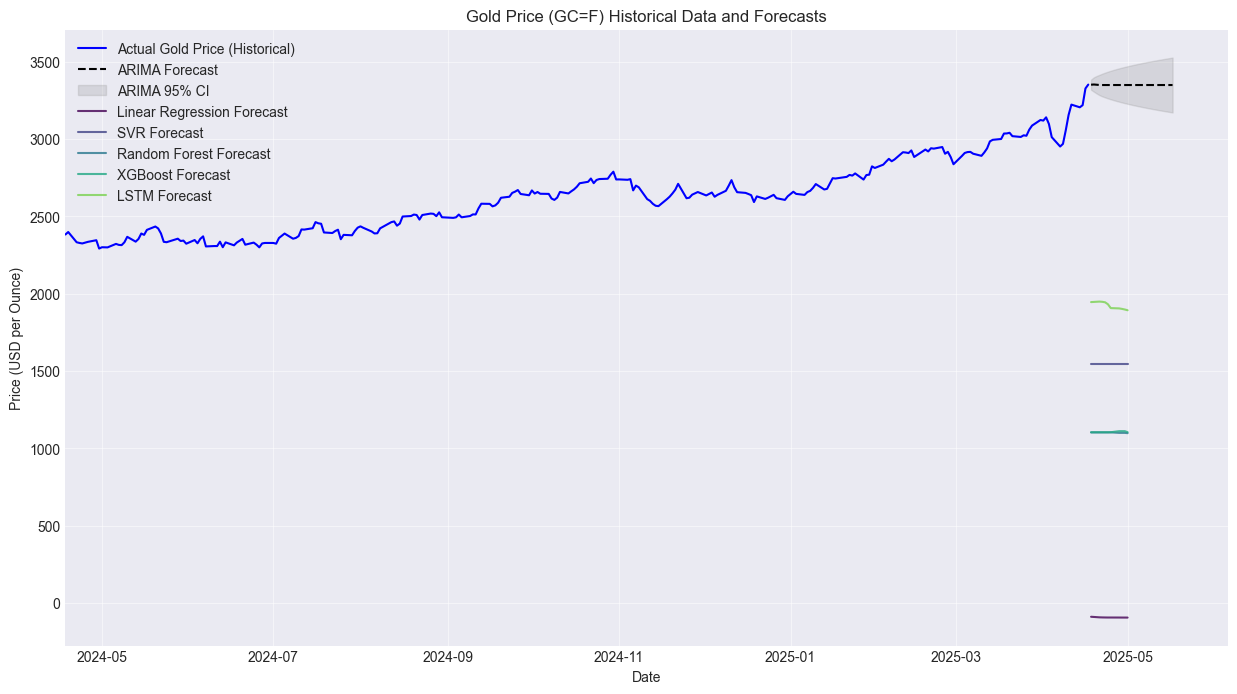

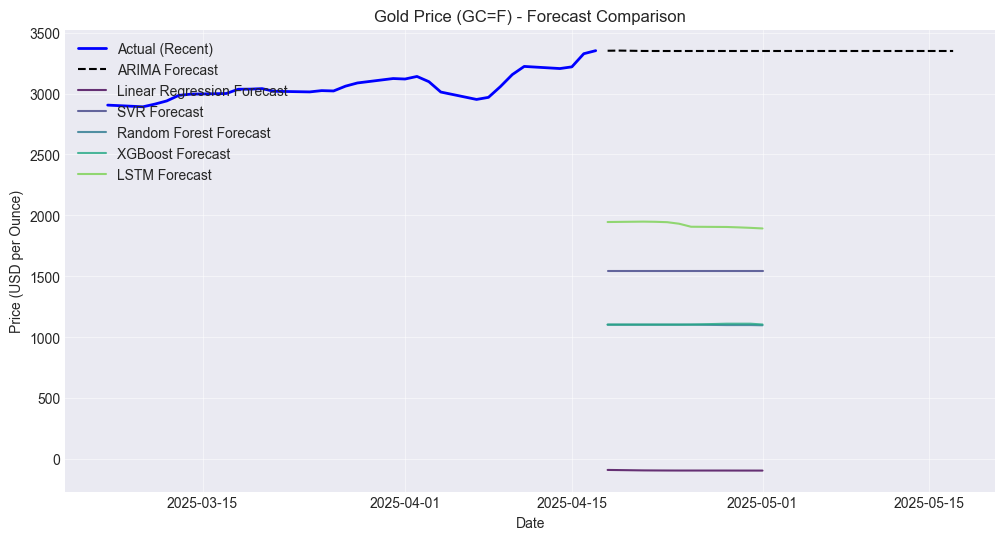

In [51]:
# --- Plot Predictions vs Actual AND Future Forecasts ---
plt.figure(figsize=(15, 8))

# Plot Historical Data (adjust how much history you want to show)
plot_start_date_hist = gold_price_close.index[-252] # Show ~1 year history
plt.plot(gold_price_close[plot_start_date_hist:], label='Actual Gold Price (Historical)', color='blue', linewidth=1.5)

# Plot ARIMA Forecast
if 'forecast_df' in locals(): # Check if ARIMA forecast exists
    plt.plot(forecast_df['mean'], label='ARIMA Forecast', color='black', linestyle='--')
    plt.fill_between(forecast_df.index,
                     forecast_df['mean_ci_lower'],
                     forecast_df['mean_ci_upper'],
                     color='grey', alpha=0.2, label='ARIMA 95% CI')


# --- Plot ML Future Forecasts ---
plot_styles = ['-', '-.', ':', (0, (3, 1, 1, 1)), '-'] # Different linestyles
style_idx = 0
colors = plt.cm.viridis(np.linspace(0, 0.8, len(ml_forecasts))) # Get distinct colors

for name, forecast in ml_forecasts.items():
    plt.plot(forecast.index, forecast, 
             label=f'{name} Forecast', 
             #linestyle=plot_styles[style_idx % len(plot_styles)], 
             color=colors[style_idx % len(colors)],
             alpha=0.8, linewidth=1.5)
    style_idx += 1


plt.title(f'Gold Price ({ticker_symbol}) Historical Data and Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.xlim(left=plot_start_date_hist) # Set x-axis limit to start of historical plot
plt.show()

# You might also want a separate plot focusing just on the forecast period
plt.figure(figsize=(12, 6))
plt.plot(gold_price_close.iloc[-30:], label='Actual (Recent)', color='blue', linewidth=2) # Last 30 actual points

# Plot ARIMA Forecast
if 'forecast_df' in locals():
    plt.plot(forecast_df['mean'], label='ARIMA Forecast', color='black', linestyle='--')

# Plot ML Future Forecasts
style_idx = 0
for name, forecast in ml_forecasts.items():
    plt.plot(forecast.index, forecast, 
             label=f'{name} Forecast', 
             #linestyle=plot_styles[style_idx % len(plot_styles)], 
             color=colors[style_idx % len(colors)],
             alpha=0.8, linewidth=1.5)
    style_idx += 1
    
plt.title(f'Gold Price ({ticker_symbol}) - Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.show()

In [52]:
garch_returns = gold_price['Log Return'].dropna() * 100 # Scale returns for stability

# --- Fit GARCH(1,1) Model ---
# p=1, q=1 are common starting points for GARCH lag orders
garch_model = arch_model(garch_returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off') # disp='off' hides convergence messages

print("\n--- GARCH Model Summary ---")
print(garch_fit.summary())



--- GARCH Model Summary ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3293.12
Distribution:                  Normal   AIC:                           6594.24
Method:            Maximum Likelihood   BIC:                           6617.56
                                        No. Observations:                 2514
Date:                Thu, Apr 17 2025   Df Residuals:                     2513
Time:                        07:40:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0253  1.7

In [53]:
forecast_horizon_garch = 30
garch_forecast = garch_fit.forecast(horizon=forecast_horizon_garch, reindex=False) # reindex=False for future dates

# Get the conditional variance forecast
forecast_variance = garch_forecast.variance.iloc[-1].values / 100**2 # Get last row, unscale
forecast_volatility = np.sqrt(forecast_variance) # Convert variance to std dev (volatility)

# Create date index for forecast
last_garch_date = garch_returns.index[-1]
garch_forecast_index = pd.date_range(start=last_garch_date + pd.Timedelta(days=1), periods=forecast_horizon_garch)

print(f"\n--- Forecasted Annualized Volatility (next {forecast_horizon_garch} days) ---")


--- Forecasted Annualized Volatility (next 30 days) ---


In [54]:
print(pd.Series(forecast_volatility * np.sqrt(252), index=garch_forecast_index).head())

2025-04-18 00:00:00-04:00    0.214101
2025-04-19 00:00:00-04:00    0.213243
2025-04-20 00:00:00-04:00    0.212395
2025-04-21 00:00:00-04:00    0.211556
2025-04-22 00:00:00-04:00    0.210728
Freq: D, dtype: float64


In [55]:
indicator_data = hist_df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
# If hist_df is not available or lacks columns, adapt based on 'gold_price'
# indicator_data = gold_price[['Close']].copy() # Minimum required is 'Close'

print("\n--- Calculating Technical Indicators ---")

# Simple Moving Averages (SMA)
indicator_data.ta.sma(length=10, append=True) # Appends column 'SMA_10'
indicator_data.ta.sma(length=50, append=True) # Appends column 'SMA_50'

# Exponential Moving Averages (EMA)
indicator_data.ta.ema(length=12, append=True) # Appends column 'EMA_12'
indicator_data.ta.ema(length=26, append=True) # Appends column 'EMA_26'

# Moving Average Convergence Divergence (MACD)
# Appends MACD_12_26_9, MACDh_12_26_9 (histogram), MACDs_12_26_9 (signal)
indicator_data.ta.macd(fast=12, slow=26, signal=9, append=True)

# Relative Strength Index (RSI)
indicator_data.ta.rsi(length=14, append=True) # Appends 'RSI_14'

# Average Directional Index (ADX) - Trend strength
# Requires High, Low, Close. Appends ADX_14, DMP_14, DMN_14
if all(col in indicator_data.columns for col in ['High', 'Low', 'Close']):
    indicator_data.ta.adx(length=14, append=True)
else:
    print("Skipping ADX: Requires 'High', 'Low', 'Close' columns.")

# Bollinger Bands®
# Appends BBL_5_2.0 (Lower), BBM_5_2.0 (Middle/SMA), BBU_5_2.0 (Upper), BBB_5_2.0 (Bandwidth), BBP_5_2.0 (Percent)
indicator_data.ta.bbands(length=20, std=2, append=True)

# Average True Range (ATR) - Volatility measure
# Requires High, Low, Close. Appends ATR_14
if all(col in indicator_data.columns for col in ['High', 'Low', 'Close']):
    indicator_data.ta.atr(length=14, append=True)
else:
    print("Skipping ATR: Requires 'High', 'Low', 'Close' columns.")

# On Balance Volume (OBV)
# Requires Close and Volume. Appends 'OBV'
if 'Volume' in indicator_data.columns and indicator_data['Volume'].sum() > 0:
     # Check if Volume data seems valid (not all zeros)
    indicator_data.ta.obv(append=True)
else:
    print("Skipping OBV: Requires 'Volume' column with non-zero data.")

# Select only the indicator columns we just added to avoid duplication later
# List comprehension to find columns added by pandas_ta (heuristic: check for '_', or specific names)
# Or manually list the expected column names based on the appends above.
indicator_columns = [
    'SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_12_26_9', 'MACDh_12_26_9',
    'MACDs_12_26_9', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14', 'BBL_20_2.0',
    'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'ATR_14', 'OBV'
]
# Filter down to only columns that were actually created (handles cases where requirements weren't met)
final_indicator_columns = [col for col in indicator_columns if col in indicator_data.columns]
tech_indicators_df = indicator_data[final_indicator_columns]

print(f"Successfully calculated indicators: {final_indicator_columns}")
print("\n--- Technical Indicators DataFrame (Tail) ---")
print(tech_indicators_df.tail())


ml_data = gold_price[['Close', 'Log Return']].join(tech_indicators_df)

# --- Create Target Variable (Shift FUTURE price to current row) ---
ml_data['Target'] = ml_data[PREDICTION_TARGET].shift(-FORECAST_HORIZON)

# --- Create Lag Features (Lag PAST prices/returns) ---
# Use 'Close' price for lags, matching the target PREDICTION_TARGET
for i in range(1, N_LAG_FEATURES + 1):
    ml_data[f'Price_Lag_{i}'] = ml_data[PREDICTION_TARGET].shift(i)

# --- Create Rolling Features (Based on PAST prices) ---
# Use .shift(FORECAST_HORIZON) to ensure rolling stats use data available *before* the target time
ml_data['Rolling_Mean'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).mean()
ml_data['Rolling_Std'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).std()

original_len = len(ml_data)
ml_data = ml_data.dropna()
print(f"\nDropped {original_len - len(ml_data)} rows with NaNs after feature engineering.")

# --- Define Features (X) and Target (y) ---
# Features now include lags, rolling stats, AND technical indicators
features = [col for col in ml_data.columns if col not in ['Close', 'Log Return', 'Target']]
X = ml_data[features]
y = ml_data['Target']



--- Calculating Technical Indicators ---
Successfully calculated indicators: ['SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'OBV']

--- Technical Indicators DataFrame (Tail) ---
                                SMA_10       SMA_50       EMA_12       EMA_26  \
Date                                                                            
2025-04-11 00:00:00-04:00  3084.419971  2965.873999  3079.625226  3034.074652   
2025-04-14 00:00:00-04:00  3092.619971  2973.720000  3098.882891  3046.720977   
2025-04-15 00:00:00-04:00  3102.599976  2981.416001  3117.316285  3059.460161   
2025-04-16 00:00:00-04:00  3121.269995  2990.882002  3149.513794  3079.248304   
2025-04-17 00:00:00-04:00  3146.730005  3000.482002  3180.603995  3099.422511   

                           MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
Date                      

## Visualisation

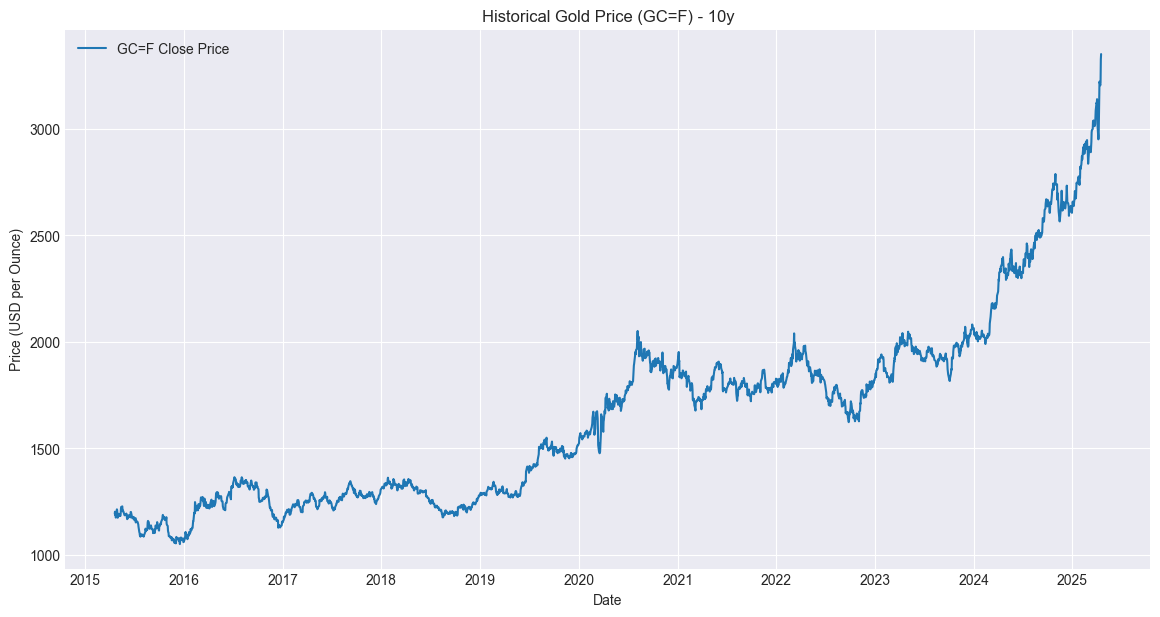

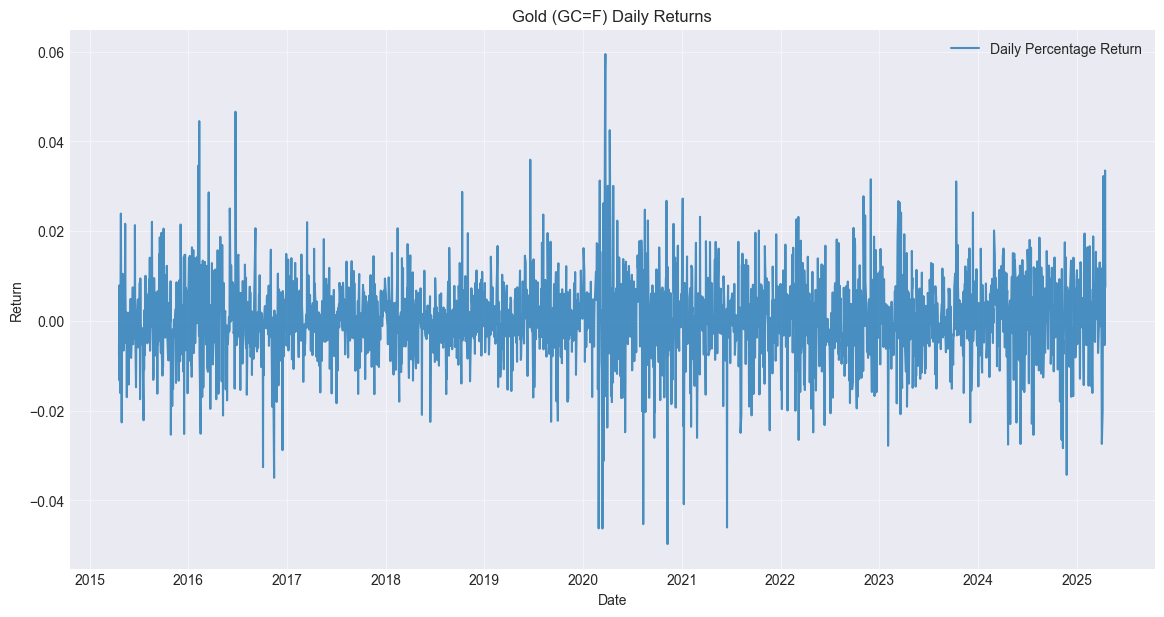

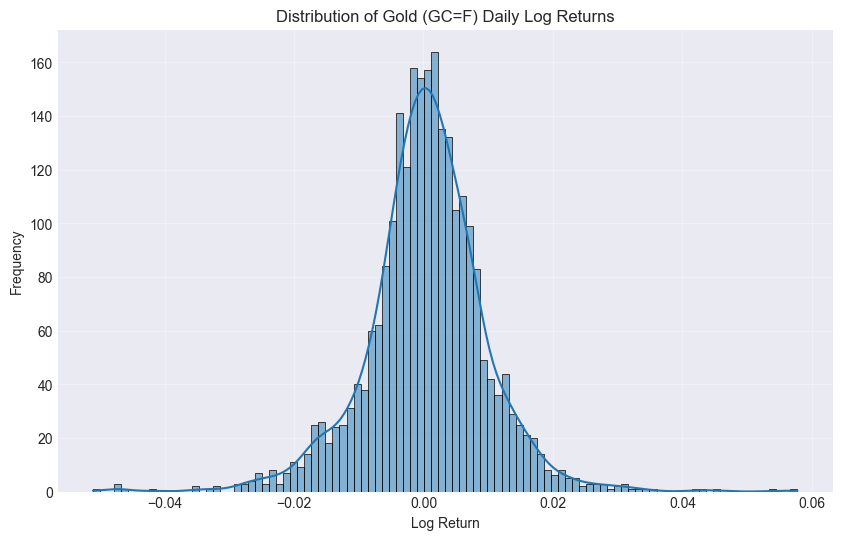

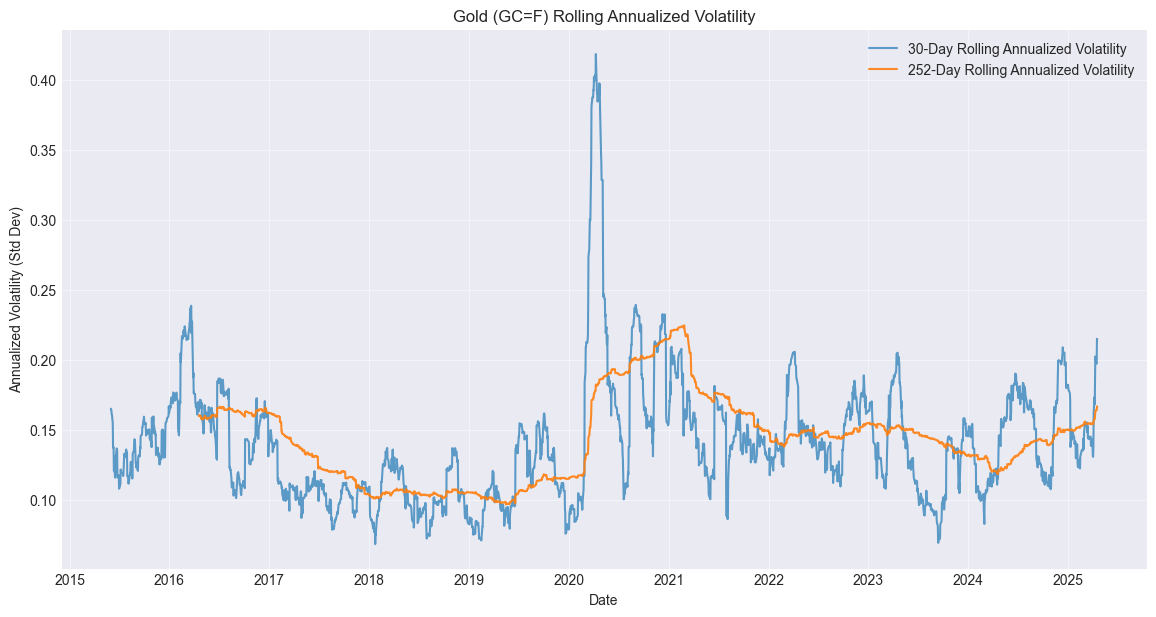

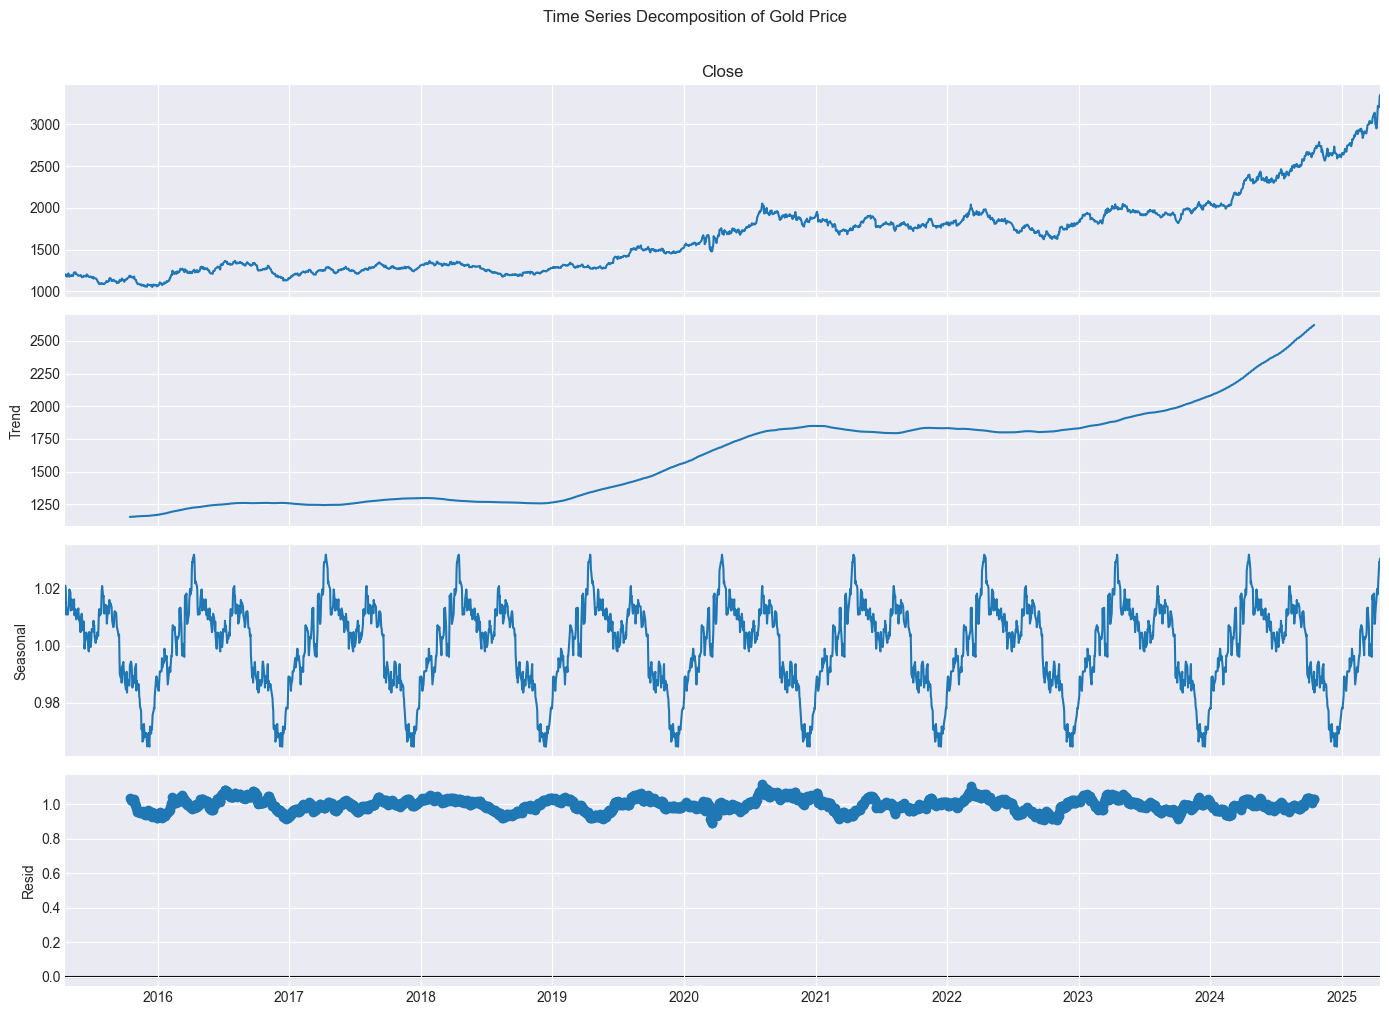

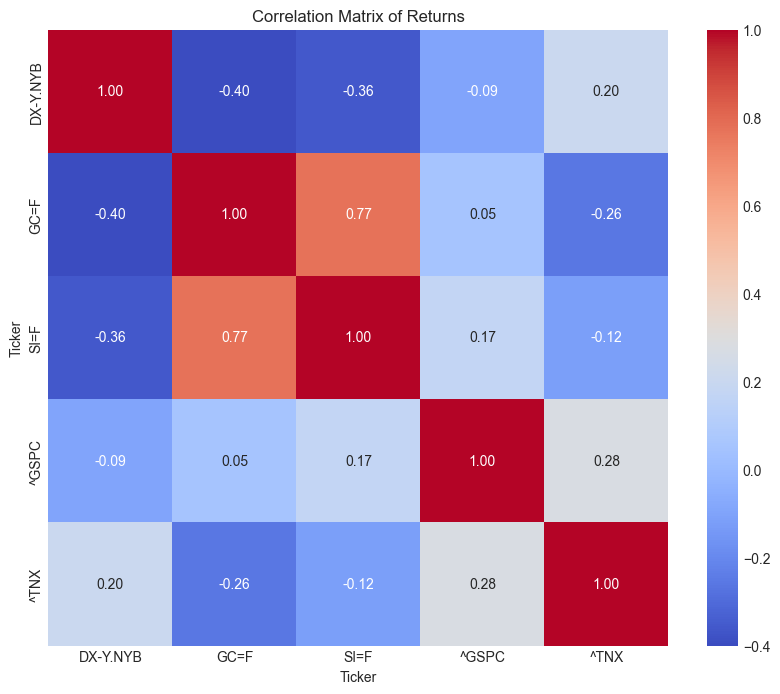

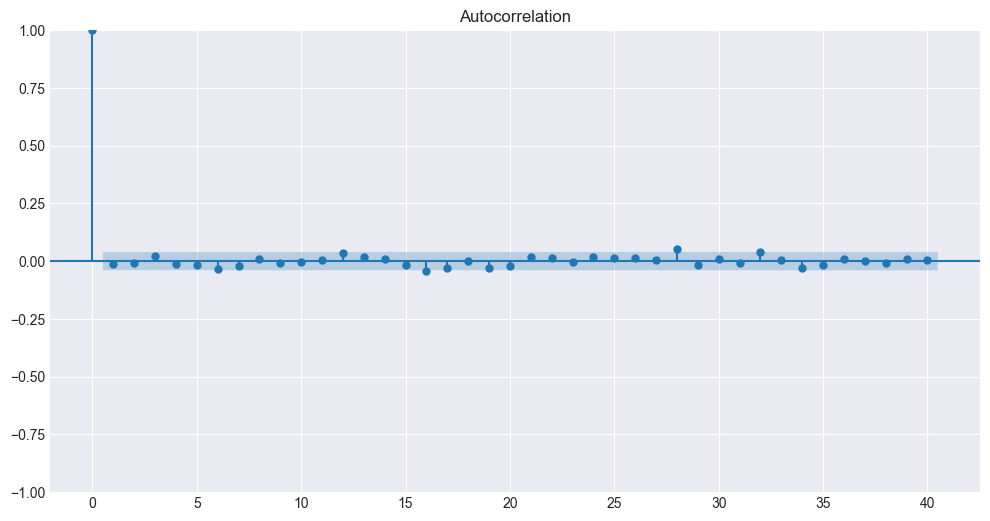

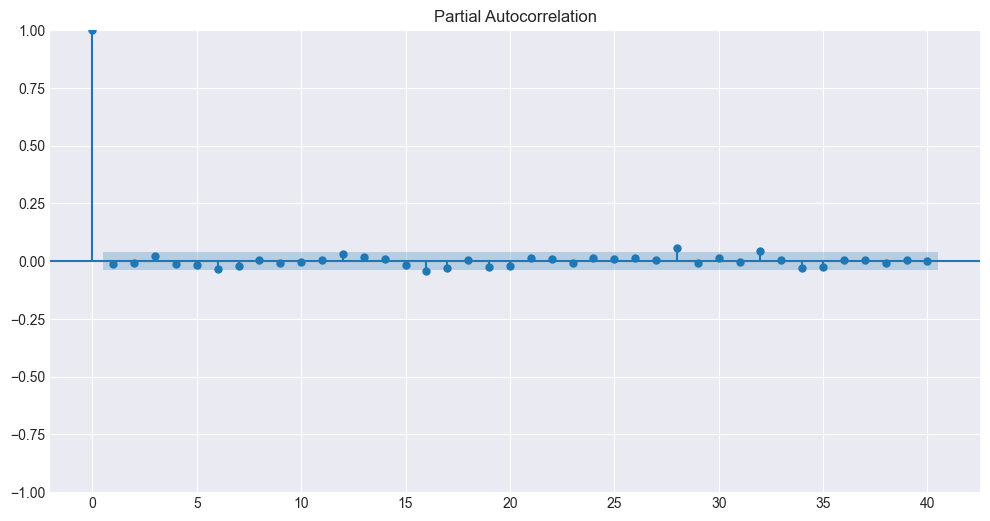

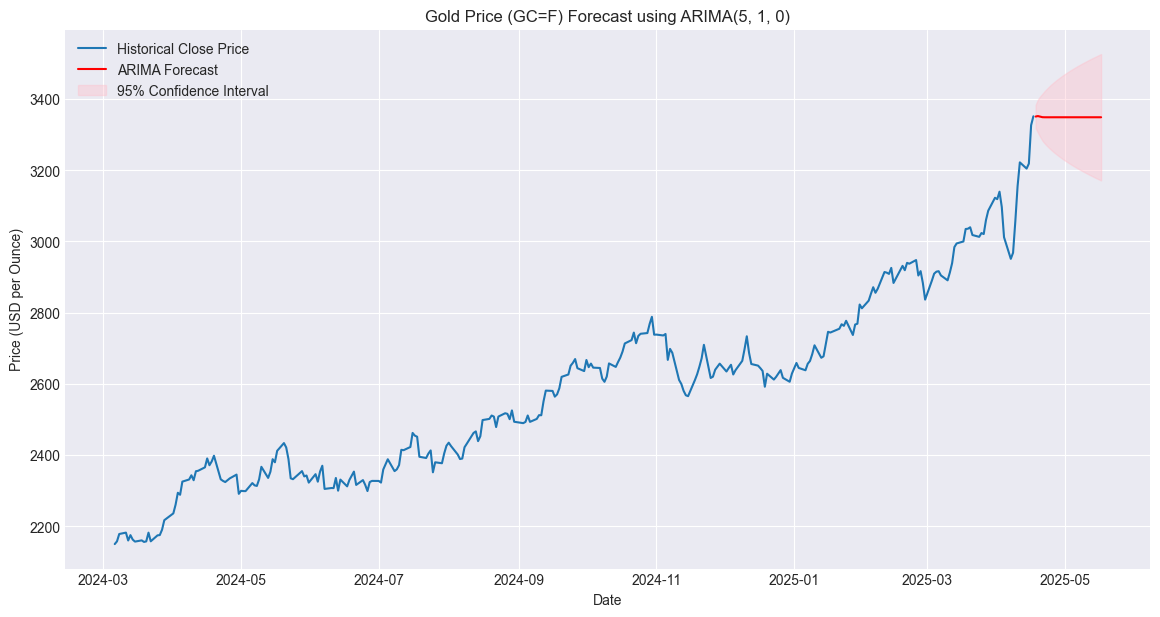

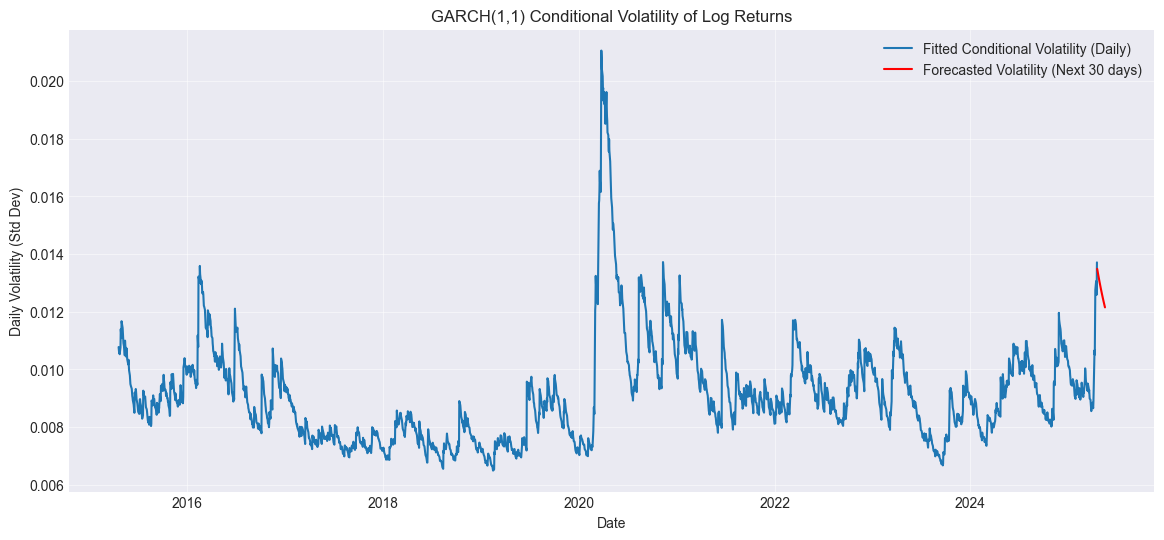


--- Model Performance Comparison (Lower is Better) ---
                         RMSE         MAE
Linear Regression   71.782454   55.946256
Random Forest      534.864849  401.646858
XGBoost            568.180474   439.41168
LSTM               574.823656  468.383495
SVR                808.269075  665.929817


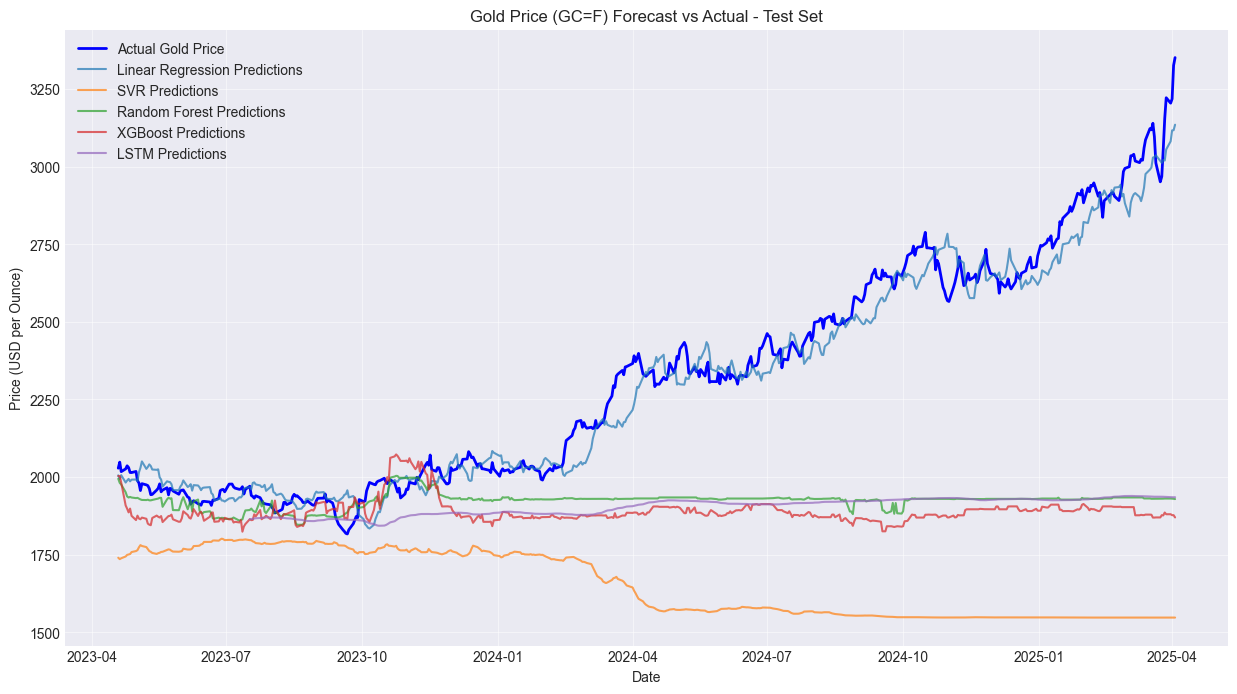

Plotting last 100 days for technical indicators.


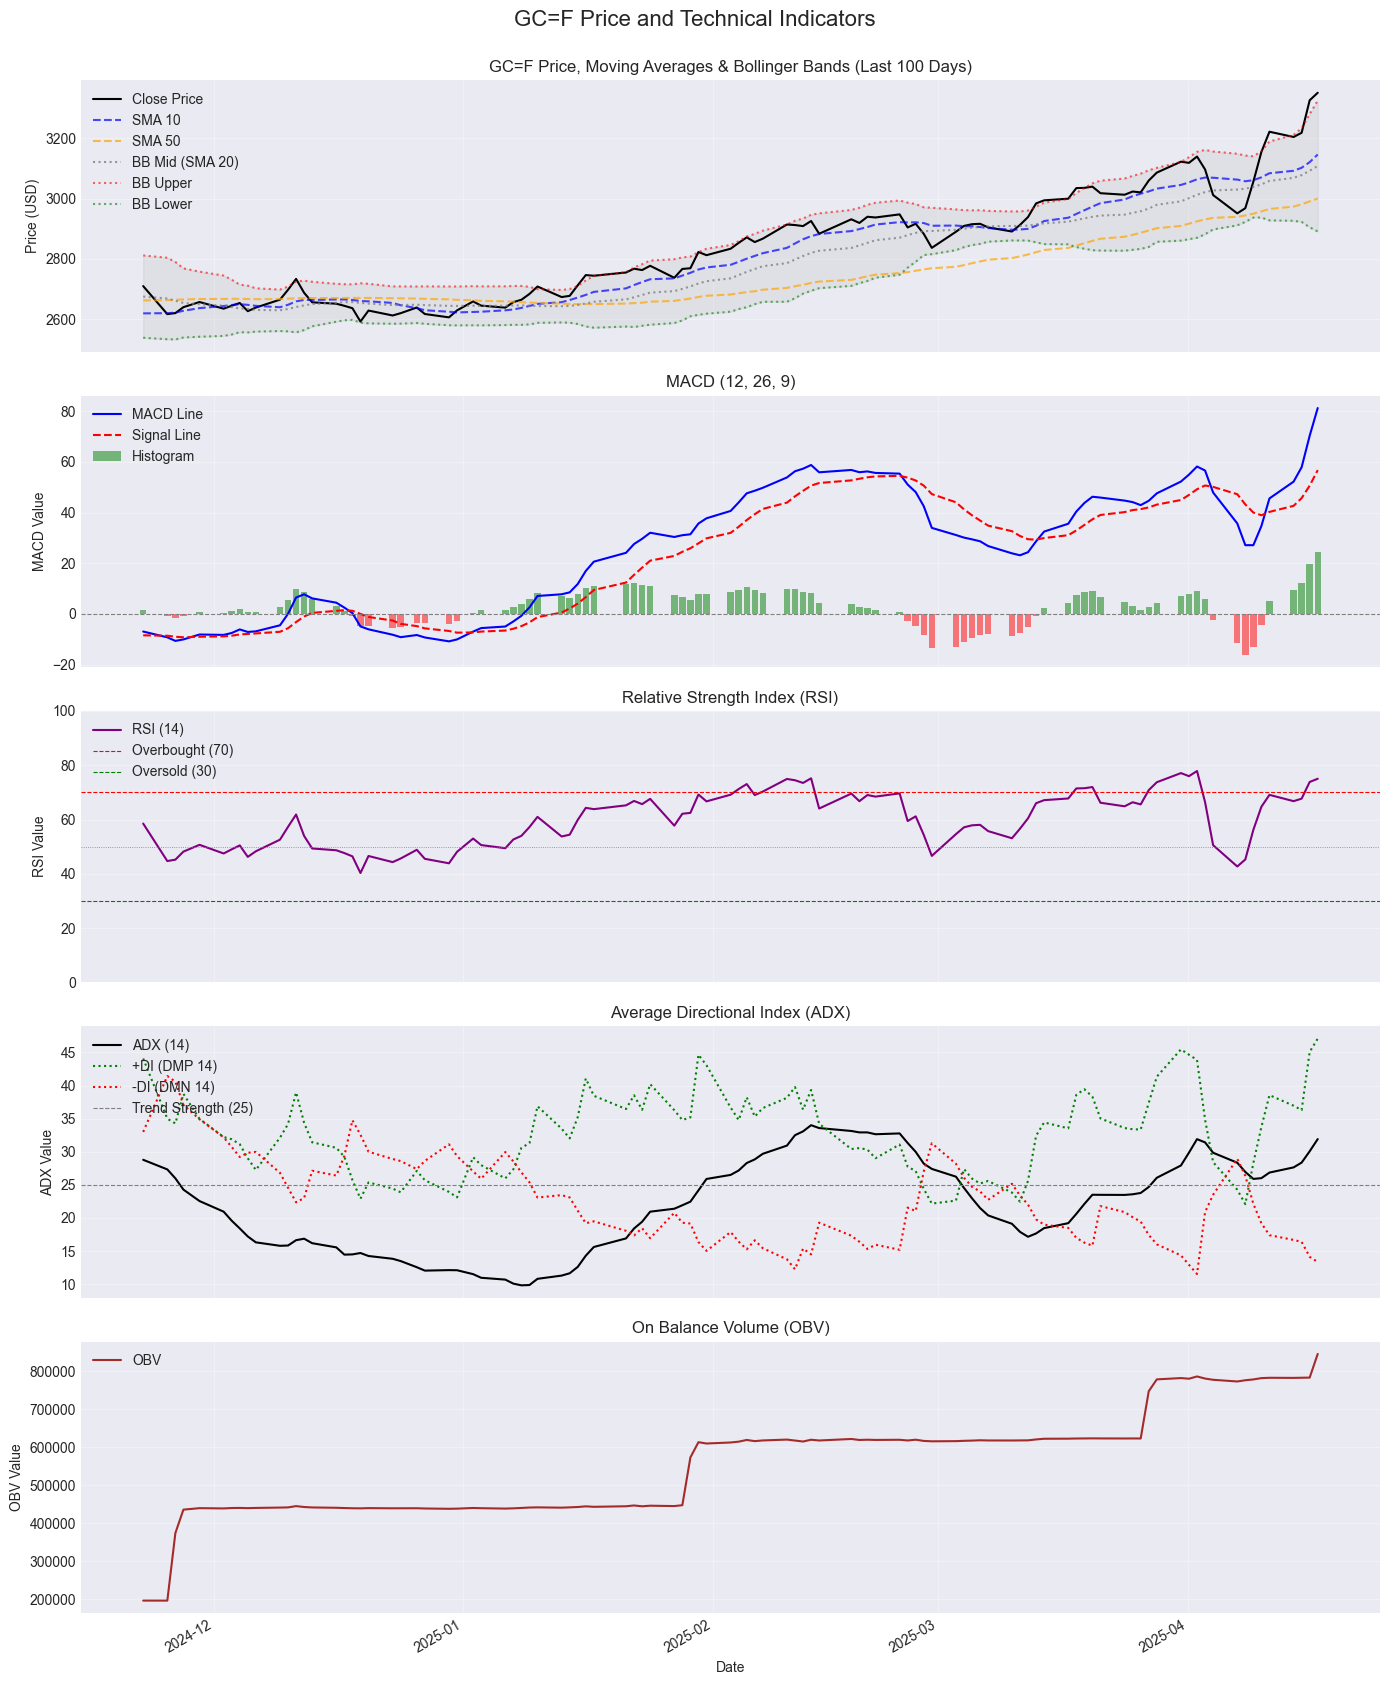

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(gold_price['Close'], label=f'{ticker_symbol} Close Price')
plt.title(f'Historical Gold Price ({ticker_symbol}) - {data_period}')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Daily Return'], label='Daily Percentage Return', alpha=0.8)
plt.title(f'Gold ({ticker_symbol}) Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(gold_price['Log Return'], bins=100, kde=True)
plt.title(f'Distribution of Gold ({ticker_symbol}) Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Rolling Volatility (30d)'], label=f'{rolling_window_short}-Day Rolling Annualized Volatility', alpha=0.7)
plt.plot(gold_price['Rolling Volatility (252d)'], label=f'{rolling_window_long}-Day Rolling Annualized Volatility', alpha=0.9)
plt.title(f'Gold ({ticker_symbol}) Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (Std Dev)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

decomposition_period = 252 # Approx trading days in a year
if len(gold_price) > decomposition_period * 2: # Need at least 2 full periods
    result = seasonal_decompose(gold_price['Close'], model='multiplicative', period=decomposition_period)

    # Plot decomposition
    fig = result.plot()
    fig.set_size_inches(14, 10)
    fig.suptitle('Time Series Decomposition of Gold Price', y=1.01)
    plt.tight_layout()
    plt.show()

    # Extract components
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
else:
    print(f"Not enough data for decomposition with period {decomposition_period}. Need at least {decomposition_period * 2} data points.")
    trend, seasonal, residual = None, None, None # Assign None if decomposition not performed

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Returns')
plt.show()

plot_acf(gold_price['Log Return'].dropna(), lags=40)
plot_pacf(gold_price['Log Return'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(14, 7))

# Plot historical data (show maybe last year + forecast period for clarity)
plot_start_date = gold_price_close.index[-252 - forecast_steps] # Approx 1 year before forecast start
plt.plot(gold_price_close[plot_start_date:], label='Historical Close Price')

# Plot the forecast mean
plt.plot(forecast_df['mean'], label='ARIMA Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.4, label='95% Confidence Interval')

plt.title(f'Gold Price ({ticker_symbol}) Forecast using ARIMA{order}')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(garch_returns.index, garch_fit.conditional_volatility / 100, label='Fitted Conditional Volatility (Daily)') # Unscale
plt.plot(garch_forecast_index, forecast_volatility, label=f'Forecasted Volatility (Next {forecast_horizon_garch} days)', color='red')
plt.title('GARCH(1,1) Conditional Volatility of Log Returns')
plt.ylabel('Daily Volatility (Std Dev)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

results_df = pd.DataFrame(results).T[['RMSE', 'MAE']]
print("\n--- Model Performance Comparison (Lower is Better) ---")
print(results_df.sort_values(by='RMSE'))

# --- Plot Predictions vs Actual ---
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test, label='Actual Gold Price', color='blue', linewidth=2)

# Plot predictions for each model
for name, result_data in results.items():
    if name == 'LSTM':
        # Adjust index for LSTM predictions
        plot_index = y_test_lstm_plotting.index
        plt.plot(plot_index, result_data['Predictions'], label=f'{name} Predictions', alpha=0.7)
    else:
        # Standard ML models align directly with y_test index
        plt.plot(y_test.index, result_data['Predictions'], label=f'{name} Predictions', alpha=0.7)


plt.title(f'Gold Price ({ticker_symbol}) Forecast vs Actual - Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

if 'indicator_data' in locals():
    plot_data = indicator_data.copy()
    plot_data_subset = plot_data.iloc[-N_plot_days:] # N_plot_days is defined in your config cell (In[45])
    print(f"Plotting last {N_plot_days} days for technical indicators.")
else:
    print("Error: 'indicator_data' DataFrame not found. Cannot create plot_data_subset.")
    # Handle the error appropriately, maybe skip the indicator plot or raise an exception
    # For now, create an empty placeholder to avoid immediate error, but plots will fail:
    plot_data_subset = pd.DataFrame

plot_count = 3 # Start with Price/BB, MACD, RSI
optional_plots = []
if 'ADX_14' in plot_data_subset.columns: optional_plots.append('ADX')
if 'ATR_14' in plot_data_subset.columns: optional_plots.append('ATR')
if 'OBV' in plot_data_subset.columns: optional_plots.append('OBV')

plot_count += len(optional_plots)

fig, axes = plt.subplots(plot_count, 1, figsize=(14, plot_count * 3.5), sharex=True)
# Ensure axes is always a list, even if plot_count is 1
if plot_count == 1:
    axes = [axes]

current_ax_index = 0

# --- Plot 1: Price, Moving Averages, Bollinger Bands ---
ax = axes[current_ax_index]
ax.plot(plot_data_subset.index, plot_data_subset['Close'], label='Close Price', color='black', linewidth=1.5)

# Plot MAs if they exist
if 'SMA_10' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['SMA_10'], label='SMA 10', color='blue', linestyle='--', alpha=0.7)
if 'SMA_50' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['SMA_50'], label='SMA 50', color='orange', linestyle='--', alpha=0.7)

# Plot Bollinger Bands if they exist
if 'BBM_20_2.0' in plot_data_subset.columns: # Middle Band (usually SMA 20)
     ax.plot(plot_data_subset.index, plot_data_subset['BBM_20_2.0'], label='BB Mid (SMA 20)', color='grey', linestyle=':', alpha=0.8)
if all(c in plot_data_subset.columns for c in ['BBU_20_2.0', 'BBL_20_2.0']):
    ax.plot(plot_data_subset.index, plot_data_subset['BBU_20_2.0'], label='BB Upper', color='red', linestyle=':', alpha=0.6)
    ax.plot(plot_data_subset.index, plot_data_subset['BBL_20_2.0'], label='BB Lower', color='green', linestyle=':', alpha=0.6)
    # Fill between bands
    ax.fill_between(plot_data_subset.index, plot_data_subset['BBL_20_2.0'], plot_data_subset['BBU_20_2.0'], color='grey', alpha=0.1)

ax.set_ylabel('Price (USD)')
ax.set_title(f'{ticker_symbol} Price, Moving Averages & Bollinger Bands (Last {N_plot_days} Days)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 2: MACD ---
ax = axes[current_ax_index]
if all(c in plot_data_subset.columns for c in ['MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9']):
    ax.plot(plot_data_subset.index, plot_data_subset['MACD_12_26_9'], label='MACD Line', color='blue')
    ax.plot(plot_data_subset.index, plot_data_subset['MACDs_12_26_9'], label='Signal Line', color='red', linestyle='--')
    # Plot MACD Histogram with colors
    colors = ['green' if val >= 0 else 'red' for val in plot_data_subset['MACDh_12_26_9']]
    ax.bar(plot_data_subset.index, plot_data_subset['MACDh_12_26_9'], label='Histogram', color=colors, alpha=0.5)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line
    ax.set_ylabel('MACD Value')
    ax.set_title('MACD (12, 26, 9)')
    ax.legend(loc='upper left')
else:
    ax.text(0.5, 0.5, 'MACD data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 3: RSI ---
ax = axes[current_ax_index]
if 'RSI_14' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['RSI_14'], label='RSI (14)', color='purple')
    ax.axhline(70, color='red', linestyle='--', linewidth=0.8, label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', linewidth=0.8, label='Oversold (30)')
    ax.axhline(50, color='grey', linestyle=':', linewidth=0.6) # Midpoint line
    ax.set_ylabel('RSI Value')
    ax.set_ylim(0, 100) # RSI ranges from 0 to 100
    ax.set_title('Relative Strength Index (RSI)')
    ax.legend(loc='upper left')
else:
    ax.text(0.5, 0.5, 'RSI data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 4: ADX (Optional) ---
if 'ADX' in optional_plots:
    ax = axes[current_ax_index]
    if all(c in plot_data_subset.columns for c in ['ADX_14', 'DMP_14', 'DMN_14']):
        ax.plot(plot_data_subset.index, plot_data_subset['ADX_14'], label='ADX (14)', color='black')
        ax.plot(plot_data_subset.index, plot_data_subset['DMP_14'], label='+DI (DMP 14)', color='green', linestyle=':')
        ax.plot(plot_data_subset.index, plot_data_subset['DMN_14'], label='-DI (DMN 14)', color='red', linestyle=':')
        ax.axhline(25, color='grey', linestyle='--', linewidth=0.8, label='Trend Strength (25)') # Common threshold
        ax.set_ylabel('ADX Value')
        ax.set_title('Average Directional Index (ADX)')
        ax.legend(loc='upper left')
    else:
         ax.text(0.5, 0.5, 'ADX data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Plot 5: ATR (Optional) ---
if 'ATR' in optional_plots:
    ax = axes[current_ax_index]
    if 'ATR_14' in plot_data_subset.columns:
        ax.plot(plot_data_subset.index, plot_data_subset['ATR_14'], label='ATR (14)', color='teal')
        ax.set_ylabel('ATR Value')
        ax.set_title('Average True Range (ATR) - Volatility')
        ax.legend(loc='upper left')
    else:
        ax.text(0.5, 0.5, 'ATR data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Plot 6: OBV (Optional) ---
if 'OBV' in optional_plots:
    ax = axes[current_ax_index]
    if 'OBV' in plot_data_subset.columns:
        # OBV values can be large and not easily comparable, plot relative change or just the line
        ax.plot(plot_data_subset.index, plot_data_subset['OBV'], label='OBV', color='brown')
        # Use a secondary y-axis for OBV if its scale differs vastly from others? No, separate plot is fine.
        ax.set_ylabel('OBV Value')
        ax.set_title('On Balance Volume (OBV)')
        ax.legend(loc='upper left')
        # Turn off scientific notation on y-axis if numbers get large
        ax.ticklabel_format(style='plain', axis='y')
    else:
        ax.text(0.5, 0.5, 'OBV data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Final Touches ---
# Improve date formatting on x-axis
for ax in axes:
     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, N_plot_days // 252 * 2))) # Adjust interval based on plot duration
     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format as Year-Month

plt.xlabel('Date')
fig.autofmt_xdate() # Auto-rotate date labels
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap, leave space for suptitle
fig.suptitle(f'{ticker_symbol} Price and Technical Indicators', fontsize=16, y=0.99) # Add overall title
plt.show()

## Visualisation

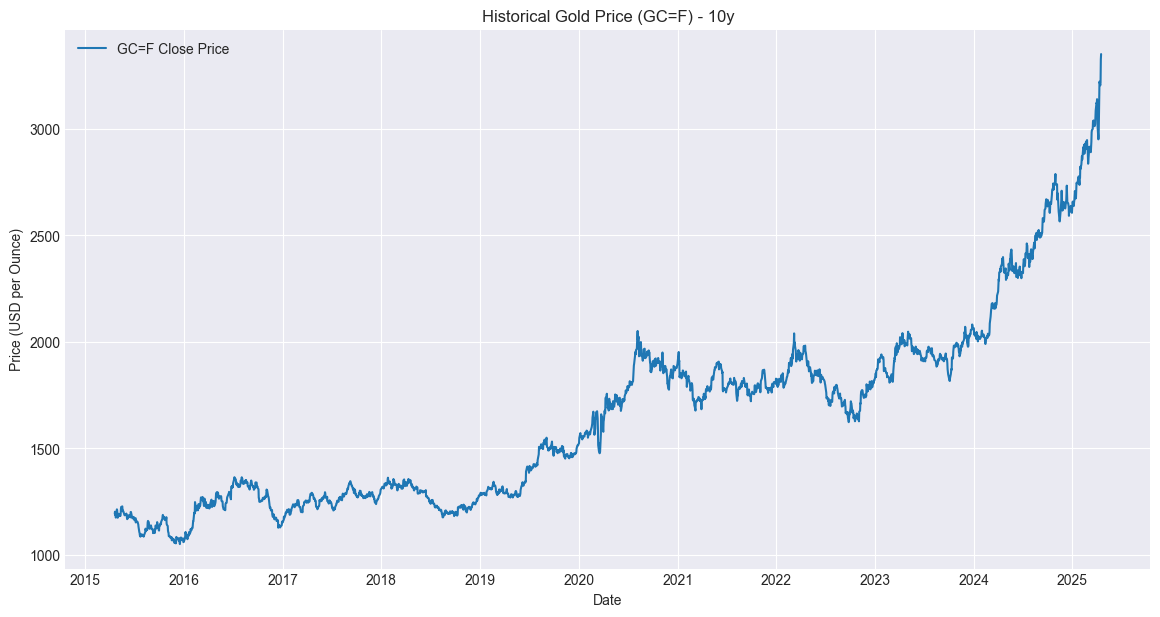

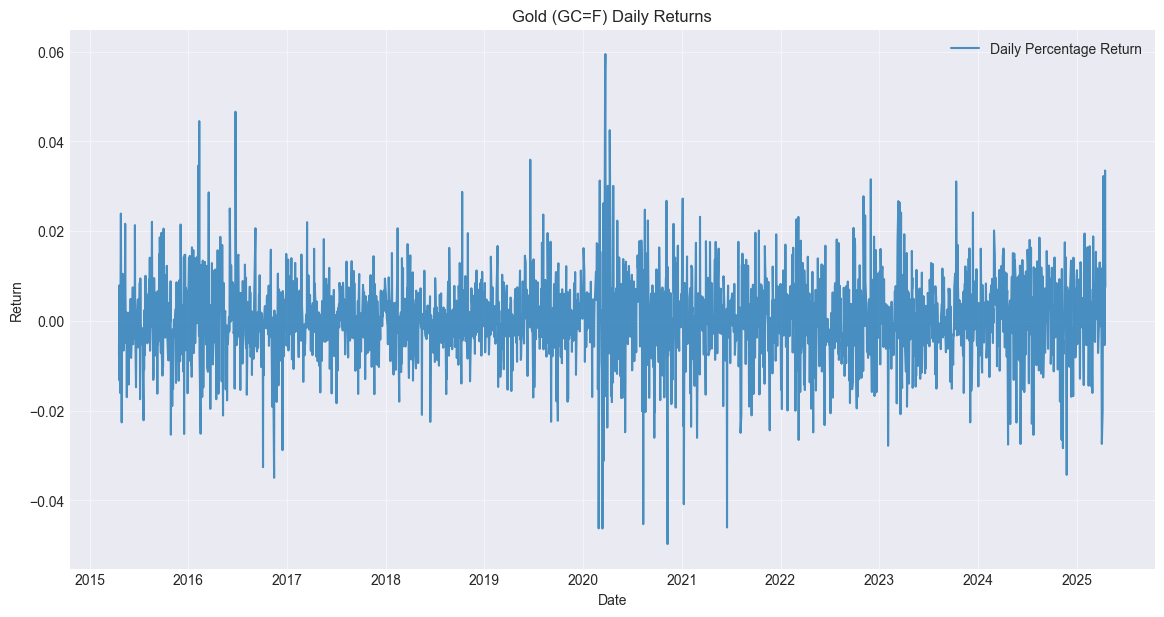

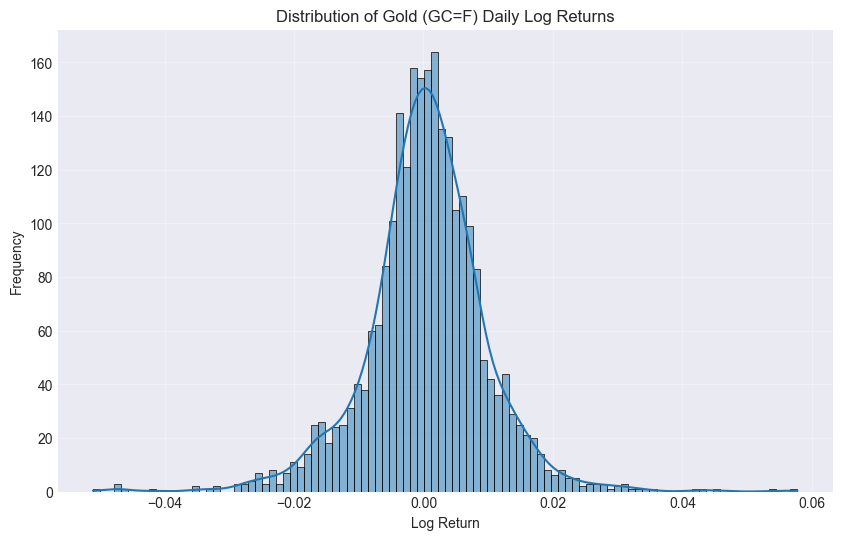

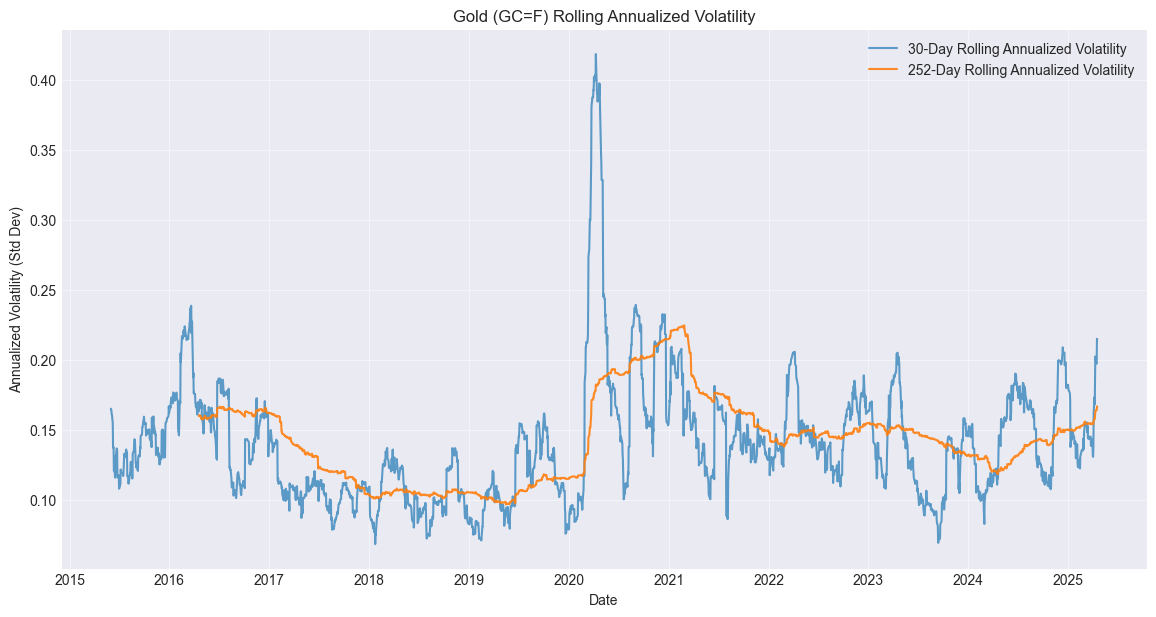

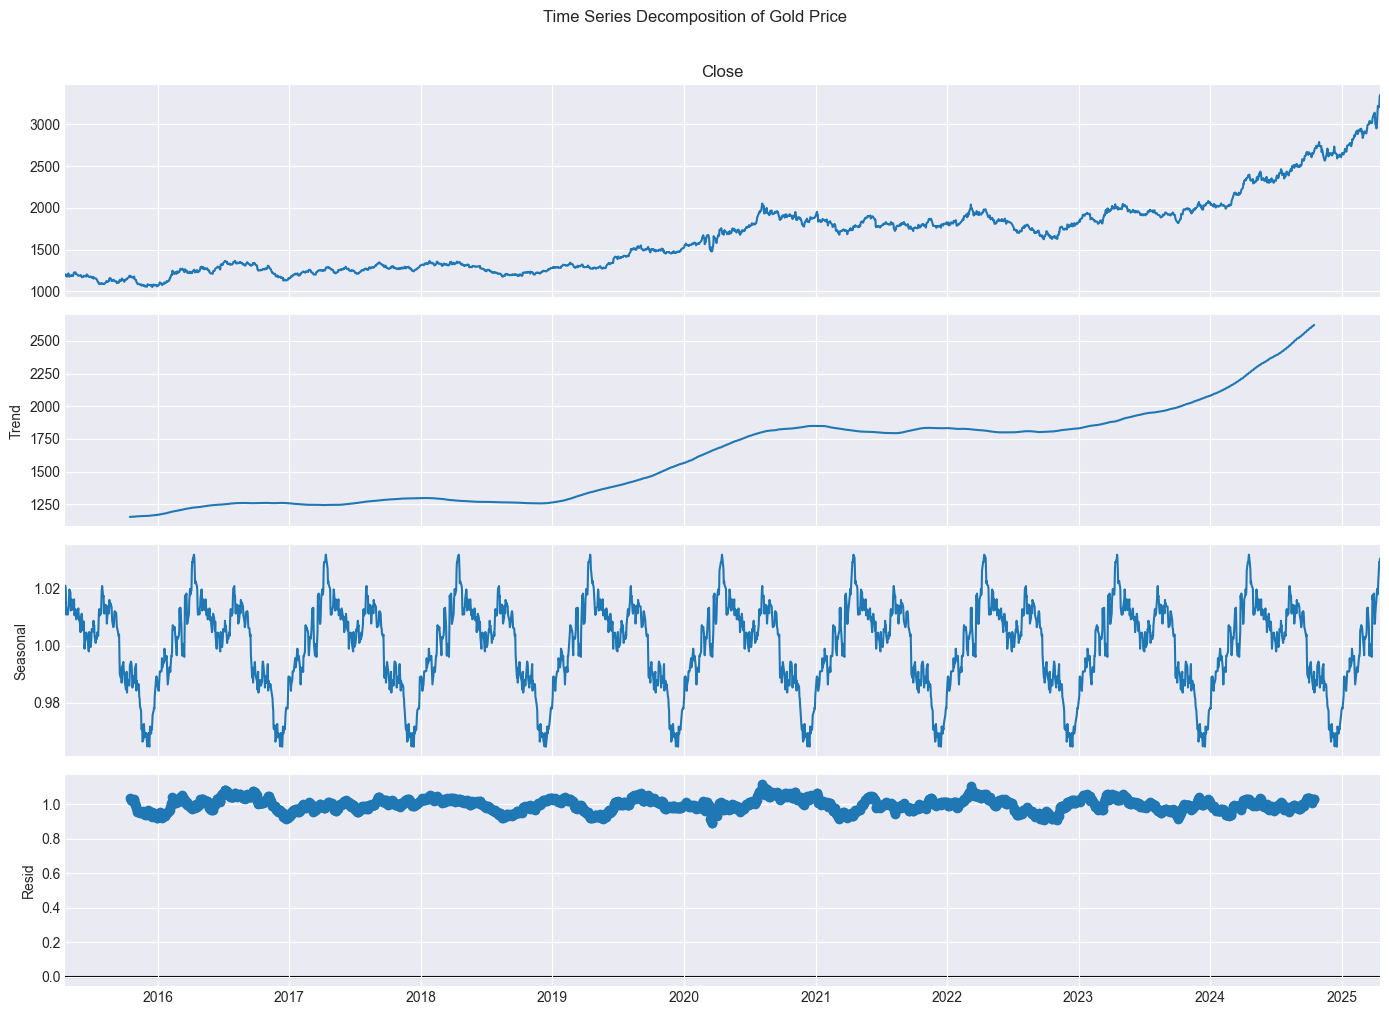

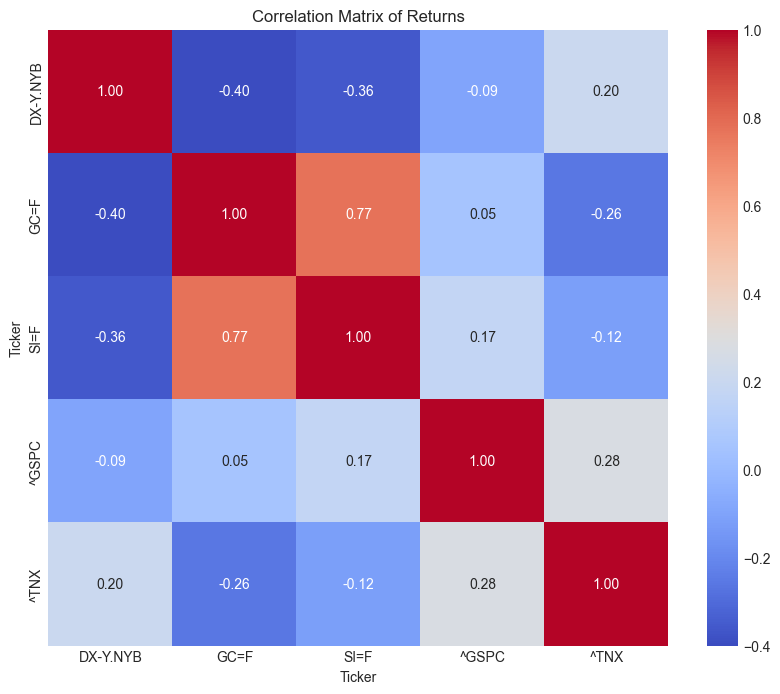

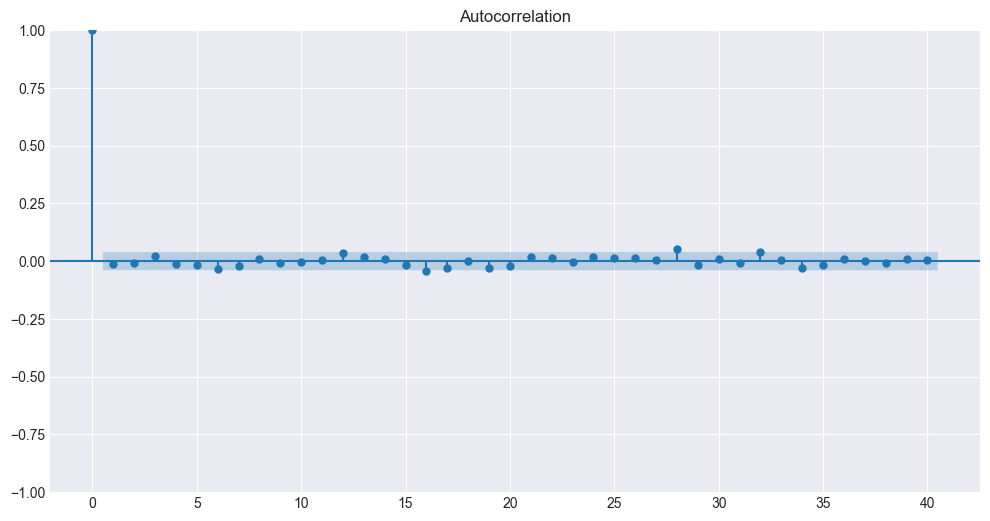

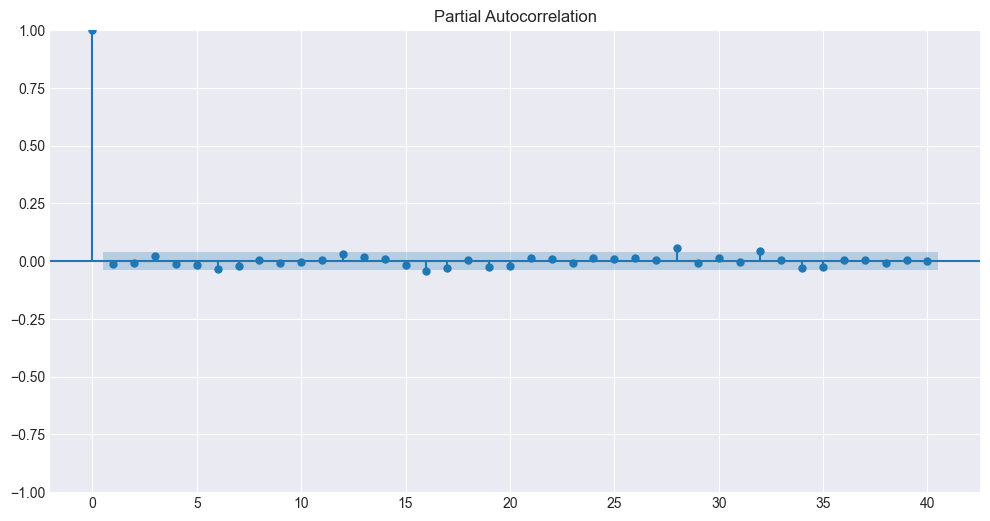

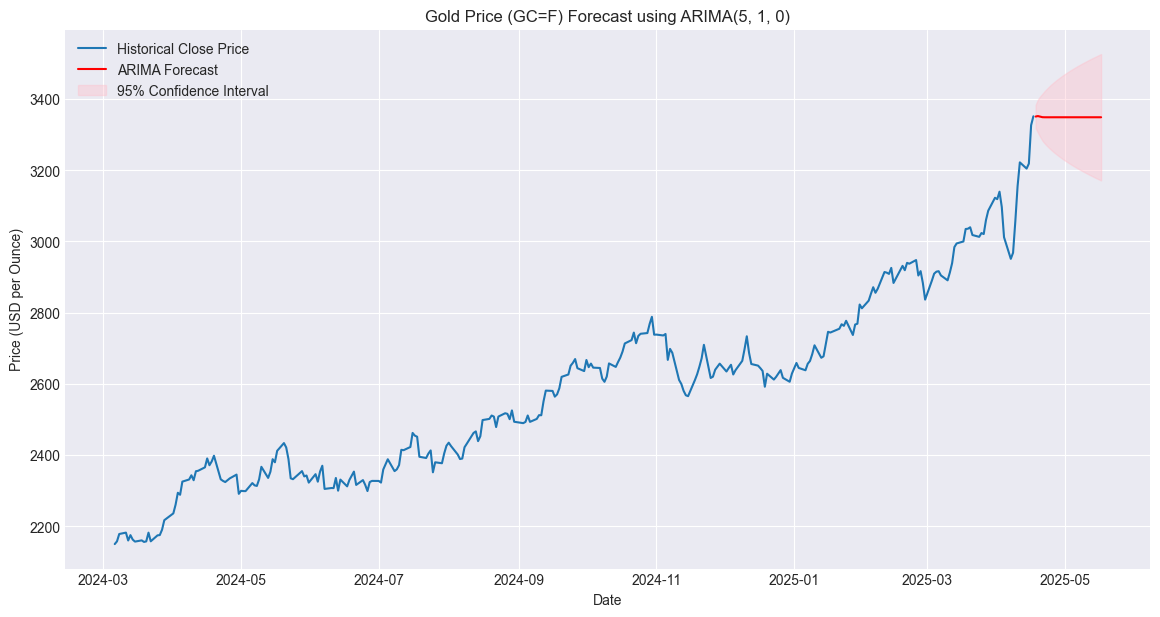

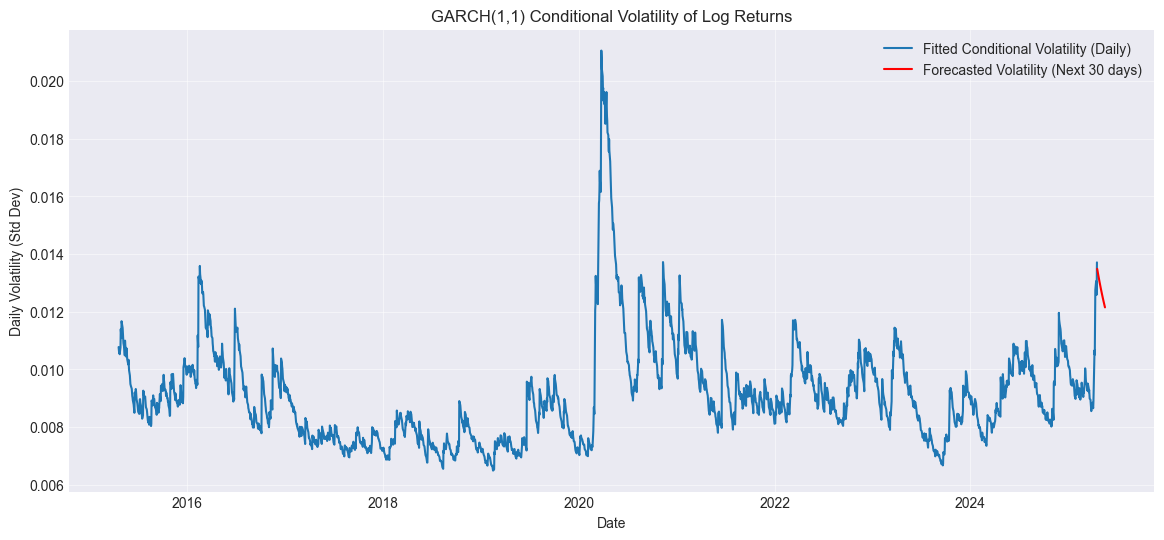


--- Model Performance Comparison (Lower is Better) ---
                         RMSE         MAE
Linear Regression   71.782454   55.946256
Random Forest      534.864849  401.646858
XGBoost            568.180474   439.41168
LSTM               574.823656  468.383495
SVR                808.269075  665.929817


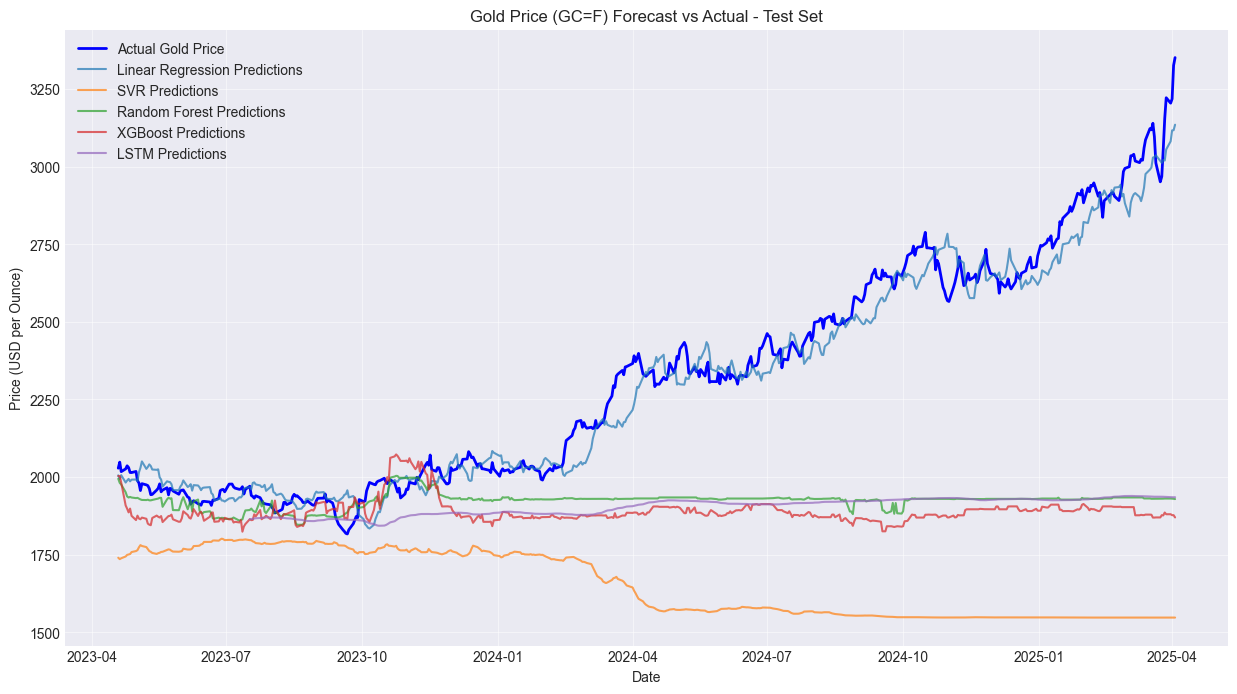

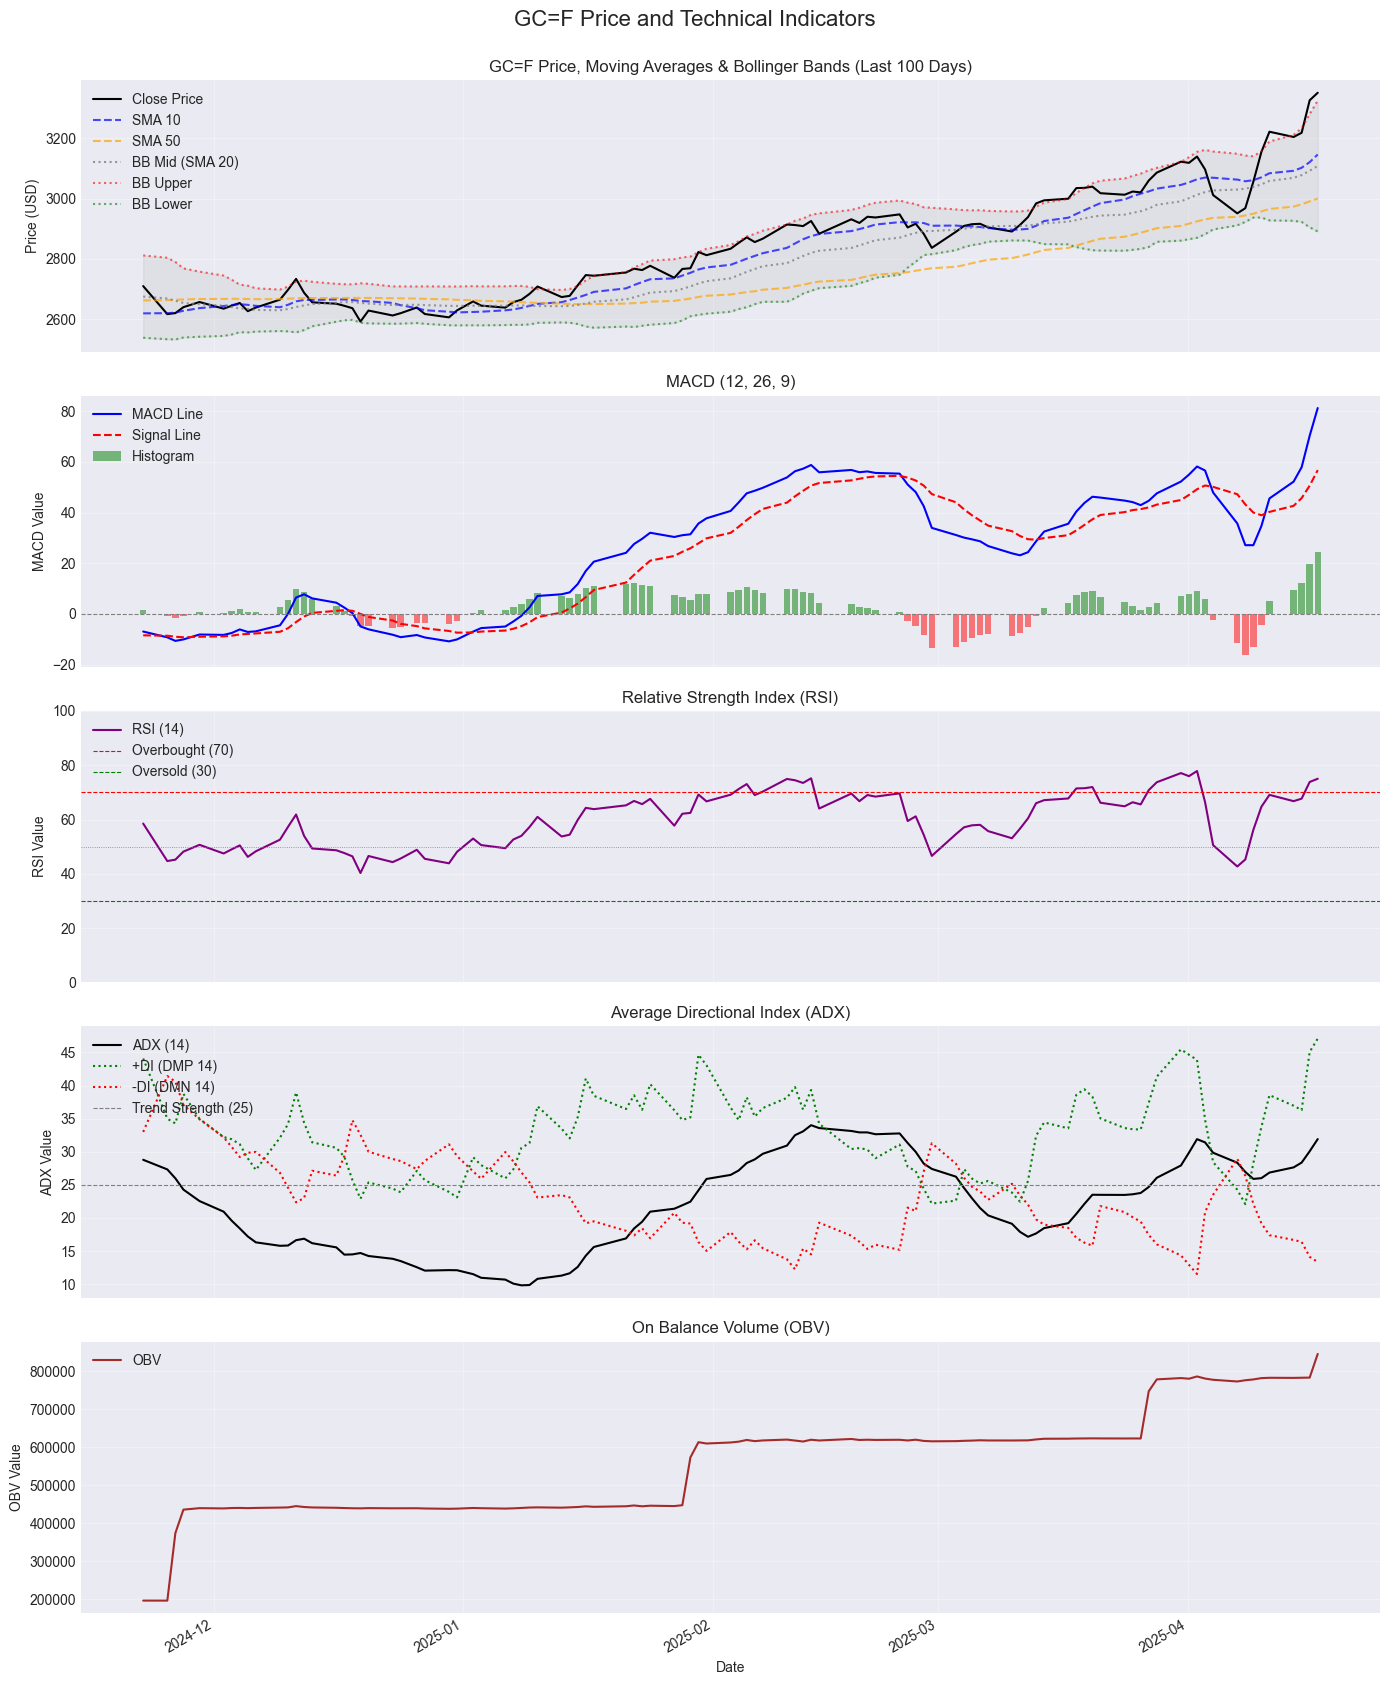

In [57]:
# ## Visualisation
plt.figure(figsize=(14, 7))
plt.plot(gold_price['Close'], label=f'{ticker_symbol} Close Price')
plt.title(f'Historical Gold Price ({ticker_symbol}) - {data_period}')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Daily Return'], label='Daily Percentage Return', alpha=0.8)
plt.title(f'Gold ({ticker_symbol}) Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(gold_price['Log Return'], bins=100, kde=True)
plt.title(f'Distribution of Gold ({ticker_symbol}) Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Rolling Volatility (30d)'], label=f'{rolling_window_short}-Day Rolling Annualized Volatility', alpha=0.7)
plt.plot(gold_price['Rolling Volatility (252d)'], label=f'{rolling_window_long}-Day Rolling Annualized Volatility', alpha=0.9)
plt.title(f'Gold ({ticker_symbol}) Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (Std Dev)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

decomposition_period = 252 # Approx trading days in a year
if len(gold_price) > decomposition_period * 2: # Need at least 2 full periods
    result = seasonal_decompose(gold_price['Close'], model='multiplicative', period=decomposition_period)

    # Plot decomposition
    fig = result.plot()
    fig.set_size_inches(14, 10)
    fig.suptitle('Time Series Decomposition of Gold Price', y=1.01)
    plt.tight_layout()
    plt.show()

    # Extract components
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
else:
    print(f"Not enough data for decomposition with period {decomposition_period}. Need at least {decomposition_period * 2} data points.")
    trend, seasonal, residual = None, None, None # Assign None if decomposition not performed

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Returns')
plt.show()

plot_acf(gold_price['Log Return'].dropna(), lags=40)
plot_pacf(gold_price['Log Return'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(14, 7))

# Plot historical data (show maybe last year + forecast period for clarity)
plot_start_date = gold_price_close.index[-252 - forecast_steps] # Approx 1 year before forecast start
plt.plot(gold_price_close[plot_start_date:], label='Historical Close Price')

# Plot the forecast mean
plt.plot(forecast_df['mean'], label='ARIMA Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.4, label='95% Confidence Interval')

plt.title(f'Gold Price ({ticker_symbol}) Forecast using ARIMA{order}')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(garch_returns.index, garch_fit.conditional_volatility / 100, label='Fitted Conditional Volatility (Daily)') # Unscale
plt.plot(garch_forecast_index, forecast_volatility, label=f'Forecasted Volatility (Next {forecast_horizon_garch} days)', color='red')
plt.title('GARCH(1,1) Conditional Volatility of Log Returns')
plt.ylabel('Daily Volatility (Std Dev)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

results_df = pd.DataFrame(results).T[['RMSE', 'MAE']]
print("\n--- Model Performance Comparison (Lower is Better) ---")
print(results_df.sort_values(by='RMSE'))

# --- Plot Predictions vs Actual ---
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test, label='Actual Gold Price', color='blue', linewidth=2)

# Plot predictions for each model
for name, result_data in results.items():
    if name == 'LSTM':
        # Adjust index for LSTM predictions
        plot_index = y_test_lstm_plotting.index
        plt.plot(plot_index, result_data['Predictions'], label=f'{name} Predictions', alpha=0.7)
    else:
        # Standard ML models align directly with y_test index
        plt.plot(y_test.index, result_data['Predictions'], label=f'{name} Predictions', alpha=0.7)


plt.title(f'Gold Price ({ticker_symbol}) Forecast vs Actual - Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD per Ounce)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

plot_count = 3 # Start with Price/BB, MACD, RSI
optional_plots = []
if 'ADX_14' in plot_data_subset.columns: optional_plots.append('ADX')
if 'ATR_14' in plot_data_subset.columns: optional_plots.append('ATR')
if 'OBV' in plot_data_subset.columns: optional_plots.append('OBV')

plot_count += len(optional_plots)

fig, axes = plt.subplots(plot_count, 1, figsize=(14, plot_count * 3.5), sharex=True)
# Ensure axes is always a list, even if plot_count is 1
if plot_count == 1:
    axes = [axes]

current_ax_index = 0

# --- Plot 1: Price, Moving Averages, Bollinger Bands ---
ax = axes[current_ax_index]
ax.plot(plot_data_subset.index, plot_data_subset['Close'], label='Close Price', color='black', linewidth=1.5)

# Plot MAs if they exist
if 'SMA_10' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['SMA_10'], label='SMA 10', color='blue', linestyle='--', alpha=0.7)
if 'SMA_50' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['SMA_50'], label='SMA 50', color='orange', linestyle='--', alpha=0.7)

# Plot Bollinger Bands if they exist
if 'BBM_20_2.0' in plot_data_subset.columns: # Middle Band (usually SMA 20)
     ax.plot(plot_data_subset.index, plot_data_subset['BBM_20_2.0'], label='BB Mid (SMA 20)', color='grey', linestyle=':', alpha=0.8)
if all(c in plot_data_subset.columns for c in ['BBU_20_2.0', 'BBL_20_2.0']):
    ax.plot(plot_data_subset.index, plot_data_subset['BBU_20_2.0'], label='BB Upper', color='red', linestyle=':', alpha=0.6)
    ax.plot(plot_data_subset.index, plot_data_subset['BBL_20_2.0'], label='BB Lower', color='green', linestyle=':', alpha=0.6)
    # Fill between bands
    ax.fill_between(plot_data_subset.index, plot_data_subset['BBL_20_2.0'], plot_data_subset['BBU_20_2.0'], color='grey', alpha=0.1)

ax.set_ylabel('Price (USD)')
ax.set_title(f'{ticker_symbol} Price, Moving Averages & Bollinger Bands (Last {N_plot_days} Days)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 2: MACD ---
ax = axes[current_ax_index]
if all(c in plot_data_subset.columns for c in ['MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9']):
    ax.plot(plot_data_subset.index, plot_data_subset['MACD_12_26_9'], label='MACD Line', color='blue')
    ax.plot(plot_data_subset.index, plot_data_subset['MACDs_12_26_9'], label='Signal Line', color='red', linestyle='--')
    # Plot MACD Histogram with colors
    colors = ['green' if val >= 0 else 'red' for val in plot_data_subset['MACDh_12_26_9']]
    ax.bar(plot_data_subset.index, plot_data_subset['MACDh_12_26_9'], label='Histogram', color=colors, alpha=0.5)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line
    ax.set_ylabel('MACD Value')
    ax.set_title('MACD (12, 26, 9)')
    ax.legend(loc='upper left')
else:
    ax.text(0.5, 0.5, 'MACD data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 3: RSI ---
ax = axes[current_ax_index]
if 'RSI_14' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['RSI_14'], label='RSI (14)', color='purple')
    ax.axhline(70, color='red', linestyle='--', linewidth=0.8, label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', linewidth=0.8, label='Oversold (30)')
    ax.axhline(50, color='grey', linestyle=':', linewidth=0.6) # Midpoint line
    ax.set_ylabel('RSI Value')
    ax.set_ylim(0, 100) # RSI ranges from 0 to 100
    ax.set_title('Relative Strength Index (RSI)')
    ax.legend(loc='upper left')
else:
    ax.text(0.5, 0.5, 'RSI data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 4: ADX (Optional) ---
if 'ADX' in optional_plots:
    ax = axes[current_ax_index]
    if all(c in plot_data_subset.columns for c in ['ADX_14', 'DMP_14', 'DMN_14']):
        ax.plot(plot_data_subset.index, plot_data_subset['ADX_14'], label='ADX (14)', color='black')
        ax.plot(plot_data_subset.index, plot_data_subset['DMP_14'], label='+DI (DMP 14)', color='green', linestyle=':')
        ax.plot(plot_data_subset.index, plot_data_subset['DMN_14'], label='-DI (DMN 14)', color='red', linestyle=':')
        ax.axhline(25, color='grey', linestyle='--', linewidth=0.8, label='Trend Strength (25)') # Common threshold
        ax.set_ylabel('ADX Value')
        ax.set_title('Average Directional Index (ADX)')
        ax.legend(loc='upper left')
    else:
         ax.text(0.5, 0.5, 'ADX data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Plot 5: ATR (Optional) ---
if 'ATR' in optional_plots:
    ax = axes[current_ax_index]
    if 'ATR_14' in plot_data_subset.columns:
        ax.plot(plot_data_subset.index, plot_data_subset['ATR_14'], label='ATR (14)', color='teal')
        ax.set_ylabel('ATR Value')
        ax.set_title('Average True Range (ATR) - Volatility')
        ax.legend(loc='upper left')
    else:
        ax.text(0.5, 0.5, 'ATR data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Plot 6: OBV (Optional) ---
if 'OBV' in optional_plots:
    ax = axes[current_ax_index]
    if 'OBV' in plot_data_subset.columns:
        # OBV values can be large and not easily comparable, plot relative change or just the line
        ax.plot(plot_data_subset.index, plot_data_subset['OBV'], label='OBV', color='brown')
        # Use a secondary y-axis for OBV if its scale differs vastly from others? No, separate plot is fine.
        ax.set_ylabel('OBV Value')
        ax.set_title('On Balance Volume (OBV)')
        ax.legend(loc='upper left')
        # Turn off scientific notation on y-axis if numbers get large
        ax.ticklabel_format(style='plain', axis='y')
    else:
        ax.text(0.5, 0.5, 'OBV data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Final Touches ---
# Improve date formatting on x-axis
for ax in axes:
     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, N_plot_days // 252 * 2))) # Adjust interval based on plot duration
     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format as Year-Month

plt.xlabel('Date')
fig.autofmt_xdate() # Auto-rotate date labels
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap, leave space for suptitle
fig.suptitle(f'{ticker_symbol} Price and Technical Indicators', fontsize=16, y=0.99) # Add overall title
plt.show()

In [31]:
hist_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-04-17 00:00:00-04:00,1200.199951,1206.000000,1200.199951,1202.900024,21,0.0,0.0
2015-04-20 00:00:00-04:00,1205.699951,1206.900024,1191.000000,1193.500000,67,0.0,0.0
2015-04-21 00:00:00-04:00,1193.199951,1202.900024,1192.800049,1202.900024,33,0.0,0.0
2015-04-22 00:00:00-04:00,1199.099976,1202.599976,1185.199951,1186.900024,93,0.0,0.0
2015-04-23 00:00:00-04:00,1187.199951,1197.000000,1186.099976,1194.400024,331,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-11 00:00:00-04:00,3182.100098,3235.000000,3182.100098,3222.199951,862,0.0,0.0
2025-04-14 00:00:00-04:00,3215.500000,3228.800049,3194.500000,3204.800049,263,0.0,0.0
2025-04-15 00:00:00-04:00,3216.000000,3218.699951,3214.000000,3218.699951,390,0.0,0.0
